In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point
from pyproj import Proj, Transformer

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-single network 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 8168.85it/s]


In [6]:
# delete 3 pairs useless and wrong edges 
edges.drop(edges[(edges['from_id'] == 771) & (edges['to_id'] == 761)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 771) & (edges['to_id'] == 766)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 762) & (edges['to_id'] == 771)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 767) & (edges['to_id'] == 771)].index, inplace=True)

edges.drop(edges[(edges['from_id'] == 780) & (edges['to_id'] == 773)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 780) & (edges['to_id'] == 772)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 774) & (edges['to_id'] == 780)].index, inplace=True)
edges.drop(edges[(edges['from_id'] == 775) & (edges['to_id'] == 780)].index, inplace=True)

edges.drop(edges[(edges['from_id'] == 180) & (edges['to_id'] == 345)].index, inplace=True)

In [7]:
# revise Zuid metro stations' coordinates, replace 712 with 180 and 345 nodes to avoid wrong shortest-path edges
geometry_value1 = nodes.loc[nodes['id'] == 180, 'geometry'].values[0]
geometry_value2 = nodes.loc[nodes['id'] == 345, 'geometry'].values[0]

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geometry'] = geometry_value1
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_x'] = geometry_value1.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_y'] = geometry_value1.y

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geometry'] = geometry_value2
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_x'] = geometry_value2.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_y'] = geometry_value2.y

In [8]:
# gpd.GeoDataFrame(edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('sub_edges_0304.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_stations[['osm_id', 'geometry','name']]).to_file('city_sub_stations_0304.GPKG',driver='GPKG')

In [9]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}

In [10]:
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [11]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

In [12]:
city_sub_order_route_dict

{'Metro 50: Gein => Isolatorweg':     id                 name                      geometry     geo_x      geo_y
 0    5                 Gein  POINT (4.9891612 52.2964067)  4.989161  52.296407
 1   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974  52.295637
 2   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126  52.298132
 3    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129  52.306869
 4    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618  52.311806
 5    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398  52.318612
 6   16         Duivendrecht  POINT (4.9365601 52.3236024)   4.93656  52.323602
 7    7      Van der Madeweg  POINT (4.9304544 52.3297847)  4.930454  52.329785
 8    9           Overamstel  POINT (4.9176063 52.3317688)  4.917606  52.331769
 9   19          Station RAI    POINT (4.889539 52.337689)  4.889539  52.337689
 10  10                 Zuid  POINT (4.8739633 52.3393223)  4.873963  52.339322
 11   8

In [13]:
# revise station sequence of 51_1 route
df51_1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df51_1 = df51_1[0::4].reset_index(drop=True)
df51_1.columns = ['name']
df51_1.name[9] = 'Zuid' 
df51_1.name[13] = 'Lelylaan' 
df51_1.name[16] = 'De Vlugtlaan' 

df51_metro = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df51_1,df51_metro,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]

key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'
city_sub_order_route_dict[key_to_replace] = df_reordered

# city_sub_order_route_dict

In [14]:
df52_metro_1 = city_sub_order_route_dict['Metro 52: Noord => Zuid']
df52_metro_2 = city_sub_order_route_dict['Metro 52: Zuid => Noord']

df52_metro_1_dep = df52_metro_1[df52_metro_1.name == 'De Pijp'].copy()
df52_metro_2_dep = df52_metro_2[df52_metro_2.name == 'De Pijp'].copy()


columns_to_swap = ['geometry', 'geo_x', 'geo_y']
for column in columns_to_swap:
    temp = df52_metro_1_dep[column].copy()
    df52_metro_1_dep.loc[df52_metro_1_dep['name'] == 'De Pijp', column] = df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column].values
    df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column] = temp.values

df52_metro_1.loc[df52_metro_1['name'] == 'De Pijp', columns_to_swap] = df52_metro_1_dep[columns_to_swap].values
df52_metro_2.loc[df52_metro_2['name'] == 'De Pijp', columns_to_swap] = df52_metro_2_dep[columns_to_swap].values

# key_to_replace52_metro_1 = 'Metro 52: Noord => Zuid'
# city_sub_order_route_dict[key_to_replace52_metro_1] = df52_metro_1
# key_to_replace52_metro_2 = 'Metro 52: Zuid => Noord'
# city_sub_order_route_dict[key_to_replace52_metro_2] = df52_metro_2
city_sub_order_route_dict

{'Metro 50: Gein => Isolatorweg':     id                 name                      geometry     geo_x      geo_y
 0    5                 Gein  POINT (4.9891612 52.2964067)  4.989161  52.296407
 1   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974  52.295637
 2   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126  52.298132
 3    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129  52.306869
 4    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618  52.311806
 5    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398  52.318612
 6   16         Duivendrecht  POINT (4.9365601 52.3236024)   4.93656  52.323602
 7    7      Van der Madeweg  POINT (4.9304544 52.3297847)  4.930454  52.329785
 8    9           Overamstel  POINT (4.9176063 52.3317688)  4.917606  52.331769
 9   19          Station RAI    POINT (4.889539 52.337689)  4.889539  52.337689
 10  10                 Zuid  POINT (4.8739633 52.3393223)  4.873963  52.339322
 11   8

In [15]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, nodes)

In [16]:
# # revise order_id_pairs of 52 routes--De pijp station where two nodes are too close
# df_order_id_52_1 = city_sub_order_id_pairs['Metro 52: Noord => Zuid']
# df_order_id_52_1
# df_order_id_52_1.e_id[4] = 863
# df_order_id_52_1.s_id[5] = 863

# df_order_id_52_2 = city_sub_order_id_pairs['Metro 52: Zuid => Noord']
# df_order_id_52_2
# df_order_id_52_2.s_id[2] = 864
# df_order_id_52_2.e_id[1] = 864

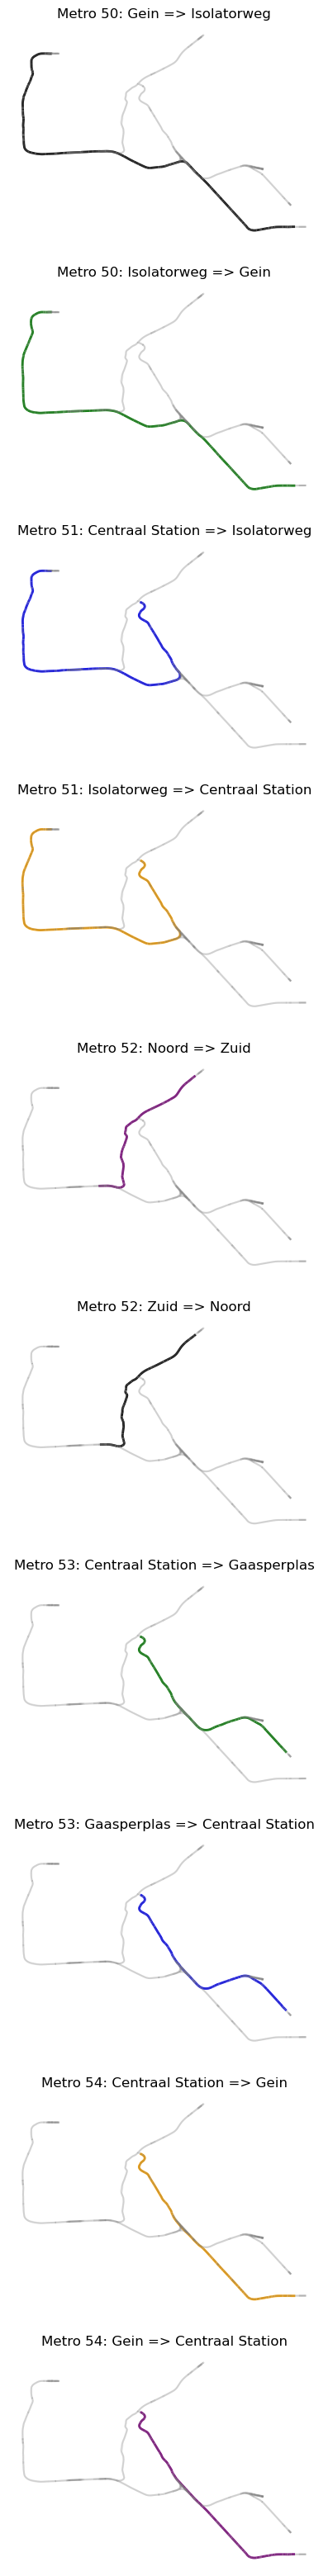

In [17]:
# Create a graph representing the subway network using the extracted edges and nodes
G = create_ground_graph(edges, nodes)

# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges = city_sub_order_id_pairs.copy()
city_sub_edges = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges[line], city_sub_edges[line] = edges_with_count_weight(city_sub_shortest_path_pairs[line], edges)
    sub_edges = city_sub_edges[line]

# # Plot the subway routes with even indices
# plot_routes_even(city_sub_routes, edges, city_sub_shortest_path_edges)

# # Plot the subway routes with odd indices
# plot_routes_odd(city_sub_routes, edges, city_sub_shortest_path_edges)
    
# Plot all subway routes
plot_routes(city_sub_routes, edges, city_sub_shortest_path_edges)

In [18]:
# df51_1 = city_sub_shortest_path_edges['Metro 50: Gein => Isolatorweg']
# df51_2 = city_sub_shortest_path_edges['Metro 50: Isolatorweg => Gein']

# df52_1 = city_sub_shortest_path_edges['Metro 52: Noord => Zuid'] 
# df52_2 = city_sub_shortest_path_edges['Metro 52: Zuid => Noord']

# df53_1 = city_sub_shortest_path_edges['Metro 53: Centraal Station => Gaasperplas']
# df53_2 = city_sub_shortest_path_edges['Metro 53: Gaasperplas => Centraal Station']

# df54_1 = city_sub_shortest_path_edges['Metro 54: Centraal Station => Gein']
# df54_2 = city_sub_shortest_path_edges['Metro 54: Gein => Centraal Station']

In [19]:
# gpd.GeoDataFrame(df51_1[['osm_id', 'geometry','id']]).to_file('df51_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df51_2[['osm_id', 'geometry','id']]).to_file('df51_2_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_1[['osm_id', 'geometry','id']]).to_file('df52_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_2[['osm_id', 'geometry','id']]).to_file('df52_2_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_1[['osm_id', 'geometry','id']]).to_file('df53_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_2[['osm_id', 'geometry','id']]).to_file('df53_2_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_1[['osm_id', 'geometry','id']]).to_file('df54_1_0314.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_2[['osm_id', 'geometry','id']]).to_file('df54_2_0314.GPKG',driver='GPKG')

## Add columns to stations

In [20]:
city_sub_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_order_route_dict, city_sub_routes)

In [21]:
city_sub_new_nodes = add_columns_to_nodes(city_sub_order_route_dict, nodes)

In [22]:
city_sub_new_nodes

geometry  degree   id                 name     geo_x  \
0   POINT (4.98916 52.29641)       2  328                 Gein  4.989161   
1   POINT (4.97400 52.29564)       2  855           Reigersbos  4.974000   
2   POINT (4.96013 52.29813)       2  854          Holendrecht  4.960126   
3   POINT (4.95213 52.30687)       2  810            Bullewijk  4.952129   
4   POINT (4.94762 52.31181)       2  809        Bijlmer ArenA  4.947618   
..                       ...     ...  ...                  ...       ...   
82  POINT (4.96734 52.32837)       2  824    Verrijn Stuartweg  4.967335   
83  POINT (4.95669 52.33041)       2  823  Station Diemen Zuid  4.956688   
84  POINT (4.94628 52.32683)       2  829         Venserpolder  4.946277   
85  POINT (4.93028 52.32974)       2  827      Van der Madeweg  4.930285   
86  POINT (4.92105 52.34029)       2  833           Spaklerweg  4.921045   

        geo_y         coordinate_value  \
0   52.296407  (4.9891612, 52.2964067)   
1   52.295637  (4.9740002, 52.2956365)   
2   52.298132  (4.9601264, 52.2981319)   
3   52.306869   (4.9521292, 52.306869)   
4   52.311806   (4.9476178, 52.311806)   
..        ...                      ...   
82  52.328367  (4.9673352, 52.3283668)   
83  52.330406  (4.9566878, 52.3304057)   
84  52.326833  (4.9462773, 52.3268326)   
85  52.329735  (4.9302846, 52.3297352)   
86  52.340287  (4.9210454, 52.3402871)   

                              route_name_list   route         ref    transfer  
0               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
1               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
2               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
3               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
4               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
..                                        ...     ...         ...         ...  
82  Metro 53: Gaasperplas => Centraal Station  subway          53        None  
83  Metro 53: Gaasperplas => Centraal Station  subway          53        None  
84  Metro 53: Gaasperplas => Centraal Station  subway          53        None  
85  Metro 53: Gaasperplas => Centraal Station  subway  50, 53, 54  50, 53, 54  
86  Metro 53: Gaasperplas => Centraal Station  subway  51, 53, 54  51, 53, 54  

[87 rows x 11 columns]

## Add columns to edges

In [23]:
city_sub_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_shortest_path_edges, city_sub_routes)

In [24]:
city_sub_new_edges = add_columns_to_edges(city_sub_shortest_path_edges,edges)

In [25]:
column_to_drop = 'count_weight'
city_sub_new_edges = city_sub_new_edges.drop(columns=column_to_drop)

In [26]:
city_sub_new_edges

osm_id                                           geometry railway  \
0      23157994  LINESTRING (4.9236699 52.3361909, 4.9236979 52...  subway   
1      23158053  LINESTRING (4.9642294 52.2945339, 4.9644259 52...  subway   
2      23158054  LINESTRING (4.9622901 52.2955678, 4.9624673 52...  subway   
3      23189033  LINESTRING (4.8467318 52.3952137, 4.8471439 52...  subway   
4      23189039  LINESTRING (4.8409161 52.3937679, 4.8416087 52...  subway   
..          ...                                                ...     ...   
948  1131538381  LINESTRING (4.9200955 52.3417374, 4.9200444 52...  subway   
949  1131538382  LINESTRING (4.9201445 52.3416568, 4.9200955 52...  subway   
950  1131538383  LINESTRING (4.9200365 52.3417239, 4.9200773 52...  subway   
951  1131538384  LINESTRING (4.9197172 52.3423576, 4.9197589 52...  subway   
952  1131538385  LINESTRING (4.9194179 52.3424458, 4.919254 52....  subway   

    service   id  from_id  to_id    distance      time  weights     to_from  \
0      None    0        0      1  258.660599  0.010346      258      (0, 1)   
1      None    1        2      3  215.433271  0.008617      215      (2, 3)   
2      None    2        4      5  121.794737  0.004872      121      (4, 5)   
3      None    3        6      7   28.046592  0.001122       28      (6, 7)   
4      None    4        8    492  382.935219  0.015317      382    (8, 492)   
..      ...  ...      ...    ...         ...       ...      ...         ...   
948    None  957      803    463   73.656989  0.002946       73  (803, 463)   
949    None  958      462    803    9.568427  0.000383        9  (462, 803)   
950    None  959      804    246    9.568874  0.000383        9  (804, 246)   
951    None  960      463    804   73.789113  0.002952       73  (463, 804)   
952    None  961      249    256   40.444210  0.001618       40  (249, 256)   

        from_to                            route_name_list   route         ref  
0        (1, 0)  Metro 51: Isolatorweg => Centraal Station  subway          51  
1        (3, 2)              Metro 50: Isolatorweg => Gein  subway      50, 54  
2        (5, 4)              Metro 50: Isolatorweg => Gein  subway      50, 54  
3        (7, 6)                                        NaN     NaN         NaN  
4      (492, 8)              Metro 50: Isolatorweg => Gein  subway      50, 51  
..          ...                                        ...     ...         ...  
948  (463, 803)  Metro 53: Gaasperplas => Centraal Station  subway      53, 54  
949  (803, 462)  Metro 53: Gaasperplas => Centraal Station  subway      53, 54  
950  (246, 804)  Metro 51: Isolatorweg => Centraal Station  subway          51  
951  (804, 463)  Metro 51: Isolatorweg => Centraal Station  subway          51  
952  (256, 249)  Metro 51: Centraal Station => Isolatorweg  subway  51, 53, 54  

[953 rows x 15 columns]

# Create original points dataframe and OD pair list

In [27]:
# origin_df = pd.DataFrame()
# each_o_point = pd.DataFrame()

# for route_name, station_df in city_sub_order_route_dict.items():
#     each_o_point = station_df.loc[[0]]
#     origin_df = pd.concat([origin_df,each_o_point])

# origin_df.drop_duplicates(subset='geometry', inplace=True)
# selected_columns = ['geometry','geo_x','geo_y','name']

# origin_df = origin_df[selected_columns].reset_index(drop=True)
# origin_df

In [28]:
# 将两个方向的同一站都保存成origin station的情况--与目前20240314的test_OD_metro冲突,暂不考虑,先保留在这--新函数可以运行这个,但是结果太多不能上传git hub
origin_df = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    first_row = station_df.iloc[0]
    last_row = station_df.iloc[-1]
    each_o_point = pd.DataFrame([first_row, last_row])
    origin_df = pd.concat([origin_df,each_o_point])

origin_df.drop_duplicates(subset='geometry', inplace=True)

selected_columns = ['geometry','geo_x','geo_y','name']
origin_df = origin_df[selected_columns].reset_index(drop=True)
origin_df 

geometry     geo_x      geo_y              name
0   POINT (4.9891612 52.2964067)  4.989161  52.296407              Gein
1   POINT (4.8505958 52.3951031)  4.850596  52.395103       Isolatorweg
2   POINT (4.8505967 52.3952329)  4.850597  52.395233       Isolatorweg
3    POINT (4.989299 52.2962711)  4.989299  52.296271              Gein
4   POINT (4.9008686 52.3773546)  4.900869  52.377355  Centraal Station
5   POINT (4.9010471 52.3775081)  4.901047  52.377508  Centraal Station
6    POINT (4.932402 52.4021571)  4.932402  52.402157             Noord
7   POINT (4.8772326 52.3393181)  4.877233  52.339318              Zuid
8   POINT (4.8780248 52.3393025)  4.878025  52.339303              Zuid
9    POINT (4.932585 52.4020575)  4.932585  52.402057             Noord
10  POINT (4.9843391 52.3111615)  4.984339  52.311161       Gaasperplas
11  POINT (4.9842364 52.3115025)  4.984236  52.311503       Gaasperplas

In [29]:
# # avoid create OD pairs from the zuid station of 52 to other stations
# row_to_drop = origin_df[origin_df.name == 'Zuid'].index
# origin_df = origin_df.drop(row_to_drop)

In [30]:
origin_df

geometry     geo_x      geo_y              name
0   POINT (4.9891612 52.2964067)  4.989161  52.296407              Gein
1   POINT (4.8505958 52.3951031)  4.850596  52.395103       Isolatorweg
2   POINT (4.8505967 52.3952329)  4.850597  52.395233       Isolatorweg
3    POINT (4.989299 52.2962711)  4.989299  52.296271              Gein
4   POINT (4.9008686 52.3773546)  4.900869  52.377355  Centraal Station
5   POINT (4.9010471 52.3775081)  4.901047  52.377508  Centraal Station
6    POINT (4.932402 52.4021571)  4.932402  52.402157             Noord
7   POINT (4.8772326 52.3393181)  4.877233  52.339318              Zuid
8   POINT (4.8780248 52.3393025)  4.878025  52.339303              Zuid
9    POINT (4.932585 52.4020575)  4.932585  52.402057             Noord
10  POINT (4.9843391 52.3111615)  4.984339  52.311161       Gaasperplas
11  POINT (4.9842364 52.3115025)  4.984236  52.311503       Gaasperplas

In [31]:
origin_name_df = origin_df[['name']]
destination_df = pd.DataFrame()
each_route_destination_df = pd.DataFrame()

for route_name, station_df in city_sub_order_route_dict.items():
    merged_df = pd.merge(station_df, origin_name_df, on='name', how='left', indicator=True)
    each_route_destination_df = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1).reset_index(drop=True)
    destination_df = pd.concat([destination_df, each_route_destination_df])
    
destination_df.drop_duplicates(subset='geometry', inplace=True)
destination_df = destination_df.reset_index(drop=True)
destination_df

id                 name                      geometry     geo_x  \
0   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974   
1   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126   
2    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129   
3    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618   
4    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398   
..  ..                  ...                           ...       ...   
66   7    Verrijn Stuartweg  POINT (4.9673352 52.3283668)  4.967335   
67   6  Station Diemen Zuid  POINT (4.9566878 52.3304057)  4.956688   
68   9         Venserpolder  POINT (4.9462773 52.3268326)  4.946277   
69   8      Van der Madeweg  POINT (4.9302846 52.3297352)  4.930285   
70  10           Spaklerweg  POINT (4.9210454 52.3402871)  4.921045   

        geo_y                            route_name_list ref   route  \
0   52.295637              Metro 50: Gein => Isolatorweg  50  subway   
1   52.298132              Metro 50: Gein => Isolatorweg  50  subway   
2   52.306869              Metro 50: Gein => Isolatorweg  50  subway   
3   52.311806              Metro 50: Gein => Isolatorweg  50  subway   
4   52.318612              Metro 50: Gein => Isolatorweg  50  subway   
..        ...                                        ...  ..     ...   
66  52.328367  Metro 53: Gaasperplas => Centraal Station  53  subway   
67  52.330406  Metro 53: Gaasperplas => Centraal Station  53  subway   
68  52.326833  Metro 53: Gaasperplas => Centraal Station  53  subway   
69  52.329735  Metro 53: Gaasperplas => Centraal Station  53  subway   
70  52.340287  Metro 53: Gaasperplas => Centraal Station  53  subway   

           coordinate_value  
0   (4.9740002, 52.2956365)  
1   (4.9601264, 52.2981319)  
2    (4.9521292, 52.306869)  
3    (4.9476178, 52.311806)  
4   (4.9413977, 52.3186119)  
..                      ...  
66  (4.9673352, 52.3283668)  
67  (4.9566878, 52.3304057)  
68  (4.9462773, 52.3268326)  
69  (4.9302846, 52.3297352)  
70  (4.9210454, 52.3402871)  

[71 rows x 9 columns]

In [32]:
destination_df[destination_df.ref == '52']

id          name                      geometry     geo_x      geo_y  \
47  3   Noorderpark  POINT (4.9181114 52.3886982)  4.918111  52.388698   
48  0         Rokin  POINT (4.8925639 52.3705391)  4.892564  52.370539   
49  6  Vijzelgracht  POINT (4.8910469 52.3606866)  4.891047  52.360687   
50  8       De Pijp  POINT (4.8906476 52.3539585)  4.890648  52.353958   
51  5   Europaplein  POINT (4.8915605 52.3411785)   4.89156  52.341178   
52  5   Europaplein  POINT (4.8914299 52.3419224)   4.89143  52.341922   
53  7       De Pijp  POINT (4.8906487 52.3539577)  4.890649  52.353958   
54  6  Vijzelgracht  POINT (4.8912207 52.3606661)  4.891221  52.360666   
55  9         Rokin  POINT (4.8927726 52.3704434)  4.892773  52.370443   
56  2   Noorderpark  POINT (4.9182755 52.3885941)  4.918276  52.388594   

            route_name_list ref   route         coordinate_value  
47  Metro 52: Noord => Zuid  52  subway  (4.9181114, 52.3886982)  
48  Metro 52: Noord => Zuid  52  subway  (4.8925639, 52.3705391)  
49  Metro 52: Noord => Zuid  52  subway  (4.8910469, 52.3606866)  
50  Metro 52: Noord => Zuid  52  subway  (4.8906476, 52.3539585)  
51  Metro 52: Noord => Zuid  52  subway  (4.8915605, 52.3411785)  
52  Metro 52: Zuid => Noord  52  subway  (4.8914299, 52.3419224)  
53  Metro 52: Zuid => Noord  52  subway  (4.8906487, 52.3539577)  
54  Metro 52: Zuid => Noord  52  subway  (4.8912207, 52.3606661)  
55  Metro 52: Zuid => Noord  52  subway  (4.8927726, 52.3704434)  
56  Metro 52: Zuid => Noord  52  subway  (4.9182755, 52.3885941)

In [33]:
OD_list = []

for index_origin, row_origin in origin_df.iterrows():
    o_geo_x = row_origin['geo_x']
    o_geo_y = row_origin['geo_y']
       
    for index_destination, row_destination in destination_df.iterrows():
        d_geo_x = row_destination['geo_x']
        d_geo_y = row_destination['geo_y']
        
        # Append a dictionary to the list
        OD_list.append({
            's_coordinates_x': o_geo_x,
            's_coordinates_y': o_geo_y,
            'e_coordinates_x': d_geo_x,
            'e_coordinates_y': d_geo_y
        })

# Create a DataFrame from the list of dictionaries
OD_df = pd.DataFrame(OD_list)  

In [34]:
OD_df

s_coordinates_x  s_coordinates_y  e_coordinates_x  e_coordinates_y
0           4.989161        52.296407         4.974000        52.295637
1           4.989161        52.296407         4.960126        52.298132
2           4.989161        52.296407         4.952129        52.306869
3           4.989161        52.296407         4.947618        52.311806
4           4.989161        52.296407         4.941398        52.318612
..               ...              ...              ...              ...
847         4.984236        52.311503         4.967335        52.328367
848         4.984236        52.311503         4.956688        52.330406
849         4.984236        52.311503         4.946277        52.326833
850         4.984236        52.311503         4.930285        52.329735
851         4.984236        52.311503         4.921045        52.340287

[852 rows x 4 columns]

In [35]:
# # delete the OD pairs from central station to other stations of 52 
# start_index1 = 199
# end_index1 = 210
# OD_df = OD_df.drop(range(start_index1, end_index1 + 1))
# OD_df = OD_df.reset_index(drop = True)
# OD_df

# Test OD pairs

In [36]:
# # revise test_OD_metro_new to return a dictionary where the keys are the indices and the values are the shortest_path_edges_way dataframes
# def test_OD_metro_new_dict(OD_df, city_sub_new_nodes, city_sub_new_edges, city_sub_routes, city_sub_order_route_dict):
#     """
#     Calculate shortest paths between origin-destination pairs in OD_df considering metro routes.

#     Parameters:
#         OD_df (pandas.DataFrame): DataFrame containing origin-destination pairs.
#         city_sub_new_nodes (pandas.DataFrame): DataFrame containing node information.
#         city_sub_new_edges (pandas.DataFrame): DataFrame containing edge information.
#         city_sub_routes (pandas.DataFrame): DataFrame containing metro routes.
#         city_sub_order_route_dict (dict): Dictionary mapping route orders to routes.

#     Returns:
#         dict: A dictionary where keys are the indices and values are the shortest_path_edges_way dataframes.
#     """

#     # Initialize an empty dictionary to store results
#     OD_edges_result_dict = {}

#     for index, row in OD_df.iterrows():
#         # Get origin-destination pair
#         OD_pair = pd.Series(row)
#         start_node, end_node = s_e_node_df(OD_pair, city_sub_new_nodes)

#         # Check if start and end nodes are on the same route
#         s_on_route_ref, e_on_route_ref = s_e_on_route_ref(start_node, end_node)
#         s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)
#         s_e_same_routes_df = s_e_same_routes(s_on_route_ref, e_on_route_ref)

#         if s_e_same_routes_df is None:
#             # If not on the same route, find shortest path via transfer station
#             t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)

#             # Find shortest paths from start to transfer station and transfer station to end
#             s_on_route_ref, t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
#             s_t_same_routes_df = s_e_same_routes(s_on_route_ref, t_on_route_ref)
#             all_btw_stations_on_same_route_gdf_s_t = all_stations_on_same_route_gdf_transfer(s_t_same_routes_df, city_sub_routes, city_sub_order_route_dict, start_node, t_station_node)
#             btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_t, city_sub_new_nodes)

#             t_on_route_ref, e_on_route_ref = s_e_on_route_ref(t_station_node, end_node)
#             t_e_same_routes_df = s_e_same_routes(t_on_route_ref, e_on_route_ref)
#             all_btw_stations_on_same_route_gdf_t_e = all_stations_on_same_route_gdf_transfer(t_e_same_routes_df, city_sub_routes, city_sub_order_route_dict, t_station_node, end_node)
#             btw_all_id_pairs_list_t_e = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_t_e, city_sub_new_nodes)

#             # Combine unique pairs of start-transfer and transfer-end stations
#             btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
#             btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

#             # Create ground graph
#             G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

#             # Find shortest paths from start to transfer station and transfer station to end
#             shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
#             duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
#             shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
#             duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)

#             # Combine paths from start to transfer and transfer to end
#             shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t, shortest_path_edges_way_t_e])

#         else:
#             # If on the same route, find shortest path directly
#             all_btw_stations_on_same_route_gdf_s_e = all_stations_on_same_route_gdf_transfer(s_e_same_routes_df, city_sub_routes, city_sub_order_route_dict, start_node, end_node)
#             btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_e, city_sub_new_nodes)
#             btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)

#             # Create ground graph
#             G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

#             # Find shortest paths
#             shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)
#             duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_nodes)

#         # Store the result in the dictionary
#         OD_edges_result_dict[index] = shortest_path_edges_way.copy()
#         print(index)

#     return OD_edges_result_dict

In [37]:
OD_edges_result_dict = test_OD_metro_new_dict(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict)
OD_edges_result_dict

s_node and e_node are on several same routes.
The next step is to find the same routes ---- using function 's_e_same_routes'
s_node and e_node are on same route/routes:   ref
0  50
1  54

All dataframes in the list are the same
0
s_node and e_node are on several same routes.
The next step is to find the same routes ---- using function 's_e_same_routes'
s_node and e_node are on same route/routes:   ref
0  50
1  54

All dataframes in the list are the same
1
s_node and e_node are on several same routes.
The next step is to find the same routes ---- using function 's_e_same_routes'
s_node and e_node are on same route/routes:   ref
0  50
1  54

All dataframes in the list are the same
2
s_node and e_node are on several same routes.
The next step is to find the same routes ---- using function 's_e_same_routes'
s_node and e_node are on same route/routes:   ref
0  50
1  54

All dataframes in the list are the same
3
s_node and e_node are on several same routes.
The next step is to find the same 

{0:        osm_id                                           geometry railway  \
 0   166187911  LINESTRING (4.9823107 52.2963387, 4.9838859 52...  subway   
 1   166187914  LINESTRING (4.9850607 52.2963027, 4.9855227 52...  subway   
 2   166187917  LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway   
 3   166187918  LINESTRING (4.9776921 52.2962066, 4.9783293 52...  subway   
 4   166187922  LINESTRING (4.9847395 52.2963009, 4.9850607 52...  subway   
 5   166187927  LINESTRING (4.9844451 52.2963007, 4.9847395 52...  subway   
 6   166187929  LINESTRING (4.9816763 52.2963356, 4.9823107 52...  subway   
 7   166187933  LINESTRING (4.9773808 52.2961701, 4.9776921 52...  subway   
 8   181905498  LINESTRING (4.9743668 52.2956976, 4.9756246 52...  subway   
 9   181905506  LINESTRING (4.9740002 52.2956365, 4.9743668 52...  subway   
 10  181908692  LINESTRING (4.9762604 52.296007, 4.9765098 52....  subway   
 11  181908696  LINESTRING (4.9765098 52.2960472, 4.9769403 52...  subway

In [ ]:
for i in range(len(OD_edges_result_dict)):
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))
    gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
    gpd.GeoDataFrame(OD_edges_result_dict[i].copy()).plot(ax=ax, zorder=1, linewidth=(OD_edges_result_dict[i].count_weight), color='orange')

# Test 1:

In [85]:
start_node, end_node = s_e_node_df(OD_df.iloc[455], city_sub_new_nodes)

In [86]:
start_node

geometry  degree   id   name     geo_x      geo_y  \
55  POINT (4.93240 52.40216)       2  630  Noord  4.932402  52.402157   

          coordinate_value          route_name_list   route ref transfer  
55  (4.932402, 52.4021571)  Metro 52: Noord => Zuid  subway  52     None

In [87]:
end_node

geometry  degree   id         name    geo_x      geo_y  \
34  POINT (4.94142 52.31836)       2  856  Strandvliet  4.94142  52.318362   

           coordinate_value                route_name_list   route     ref  \
34  (4.9414198, 52.3183621)  Metro 50: Isolatorweg => Gein  subway  50, 54   

   transfer  
34   50, 54

### Find the route which the s_e nodes are on----compare with new_edges instead of routes dataframe, should compare with routes dataframe

In [88]:
s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)

### Make judgement of s_e_on_route_ref

In [89]:
s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)

None of e_on_route is the same as s_on_route.
The next step is to find transfer stations of e_on_route and s_on_route ---- using function 'transfer_station'


In [90]:
s_on_route_ref

ref
0  52

In [91]:
e_on_route_ref

ref
0  50
1  54

### Find those same routes

In [92]:
s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
s_e_same_routes_df

s_node and e_node are on totally different routes

The next step is to find transfer station of s_on_route: ['52'] and e_on_route: ['50', '54']


#### Get all stations between s_e

In [46]:
# Merge transfer station edges with city sub routes
t_e_on_possible_route_df = pd.merge(s_e_same_routes_df, city_sub_routes, on='ref', how='left')
t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())

t_e_on_route_possible_gdf

ref   osm_id   route                to  \
0  51    31249  subway       Isolatorweg   
1  51  4515355  subway  Centraal Station   

                                        name                 network service  \
0  Metro 51: Centraal Station => Isolatorweg  Stadsvervoer Amsterdam    None   
1  Metro 51: Isolatorweg => Centraal Station  Stadsvervoer Amsterdam    None   

                                            geometry  
0  MULTILINESTRING ((4.90193 52.37689, 4.90202 52...  
1  MULTILINESTRING ((4.83880 52.38842, 4.83897 52...

In [47]:
t_e_on_route_possible_gdf

ref   osm_id   route                to  \
0  51    31249  subway       Isolatorweg   
1  51  4515355  subway  Centraal Station   

                                        name                 network service  \
0  Metro 51: Centraal Station => Isolatorweg  Stadsvervoer Amsterdam    None   
1  Metro 51: Isolatorweg => Centraal Station  Stadsvervoer Amsterdam    None   

                                            geometry  
0  MULTILINESTRING ((4.90193 52.37689, 4.90202 52...  
1  MULTILINESTRING ((4.83880 52.38842, 4.83897 52...

In [48]:
city_sub_order_route_dict[t_e_on_route_possible_gdf.name[0]]

id                 name                      geometry     geo_x  \
0    4     Centraal Station  POINT (4.9008686 52.3773546)  4.900869   
1   17           Nieuwmarkt  POINT (4.9009379 52.3714238)  4.900938   
2   16        Waterlooplein  POINT (4.9036061 52.3666363)  4.903606   
3   18         Weesperplein  POINT (4.9078472 52.3613094)  4.907847   
4    3         Wibautstraat  POINT (4.9118953 52.3545601)  4.911895   
5    5        Amstelstation  POINT (4.9174059 52.3466361)  4.917406   
6    6           Spaklerweg  POINT (4.9208004 52.3402348)    4.9208   
7    8           Overamstel  POINT (4.9176682 52.3316938)  4.917668   
8   15          Station RAI    POINT (4.889539 52.337689)  4.889539   
9    9                 Zuid  POINT (4.8739633 52.3393223)  4.873963   
10   7      Amstelveenseweg  POINT (4.8575709 52.3384751)  4.857571   
11  10    Henk Sneevlietweg  POINT (4.8345741 52.3463868)  4.834574   
12   2      Heemstedestraat   POINT (4.834401 52.3523291)  4.834401   
13  11             Lelylaan  POINT (4.8344667 52.3580615)  4.834467   
14  14           Postjesweg  POINT (4.8340343 52.3645962)  4.834034   
15  13  Jan van Galenstraat  POINT (4.8353639 52.3725816)  4.835364   
16  12         De Vlugtlaan   POINT (4.838233 52.3794484)  4.838233   
17   0   Station Sloterdijk  POINT (4.8389786 52.3890375)  4.838979   
18   1          Isolatorweg  POINT (4.8505958 52.3951031)  4.850596   

        geo_y                            route_name_list ref   route  \
0   52.377355  Metro 51: Centraal Station => Isolatorweg  51  subway   
1   52.371424  Metro 51: Centraal Station => Isolatorweg  51  subway   
2   52.366636  Metro 51: Centraal Station => Isolatorweg  51  subway   
3   52.361309  Metro 51: Centraal Station => Isolatorweg  51  subway   
4    52.35456  Metro 51: Centraal Station => Isolatorweg  51  subway   
5   52.346636  Metro 51: Centraal Station => Isolatorweg  51  subway   
6   52.340235  Metro 51: Centraal Station => Isolatorweg  51  subway   
7   52.331694  Metro 51: Centraal Station => Isolatorweg  51  subway   
8   52.337689  Metro 51: Centraal Station => Isolatorweg  51  subway   
9   52.339322  Metro 51: Centraal Station => Isolatorweg  51  subway   
10  52.338475  Metro 51: Centraal Station => Isolatorweg  51  subway   
11  52.346387  Metro 51: Centraal Station => Isolatorweg  51  subway   
12  52.352329  Metro 51: Centraal Station => Isolatorweg  51  subway   
13  52.358061  Metro 51: Centraal Station => Isolatorweg  51  subway   
14  52.364596  Metro 51: Centraal Station => Isolatorweg  51  subway   
15  52.372582  Metro 51: Centraal Station => Isolatorweg  51  subway   
16  52.379448  Metro 51: Centraal Station => Isolatorweg  51  subway   
17  52.389038  Metro 51: Centraal Station => Isolatorweg  51  subway   
18  52.395103  Metro 51: Centraal Station => Isolatorweg  51  subway   

           coordinate_value  
0   (4.9008686, 52.3773546)  
1   (4.9009379, 52.3714238)  
2   (4.9036061, 52.3666363)  
3   (4.9078472, 52.3613094)  
4   (4.9118953, 52.3545601)  
5   (4.9174059, 52.3466361)  
6   (4.9208004, 52.3402348)  
7   (4.9176682, 52.3316938)  
8     (4.889539, 52.337689)  
9   (4.8739633, 52.3393223)  
10  (4.8575709, 52.3384751)  
11  (4.8345741, 52.3463868)  
12   (4.834401, 52.3523291)  
13  (4.8344667, 52.3580615)  
14  (4.8340343, 52.3645962)  
15  (4.8353639, 52.3725816)  
16   (4.838233, 52.3794484)  
17  (4.8389786, 52.3890375)  
18  (4.8505958, 52.3951031)

In [49]:
all_btw_stations_on_same_route_gdf_t_e = None  

# Iterate over each edge on possible route
for i in range(len(t_e_on_route_possible_gdf)):
    # Get all stations on the possible route
    all_stations_on_possible_route_t_e = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[i]]
    all_stations_on_possible_route_t_e_gdf = gpd.GeoDataFrame(all_stations_on_possible_route_t_e.copy())

    # Convert transfer station node and end node to GeoDataFrames
    t_station_node_gdf = gpd.GeoDataFrame(start_node.copy())
    end_node_gdf = gpd.GeoDataFrame(end_node.copy())

    # Find the nearest station index to the transfer station node
    t_station_node_index = shapely.distance(t_station_node_gdf.geometry.values, all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    # Find the nearest station index to the end node
    end_station_index = shapely.distance(end_node_gdf.geometry.values, all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()

    # If transfer station index is greater than end station index, continue to next iteration
    if t_station_node_index > end_station_index:
        continue  
    else:
        # Extract stations between transfer station and end node on the same route
        all_btw_stations_on_same_route_gdf_t_e = all_stations_on_possible_route_t_e_gdf.iloc[t_station_node_index:end_station_index+1]
        break

# If no suitable stations found, raise ValueError
if all_btw_stations_on_same_route_gdf_t_e is None:
    raise ValueError("No suitable stations found.")

In [50]:
all_stations_on_possible_route_t_e

id                 name                      geometry     geo_x  \
0   12          Isolatorweg  POINT (4.8505967 52.3952329)  4.850597   
1   14   Station Sloterdijk  POINT (4.8387632 52.3890363)  4.838763   
2    2         De Vlugtlaan  POINT (4.8380564 52.3794609)  4.838056   
3   13  Jan van Galenstraat  POINT (4.8351828 52.3725841)  4.835183   
4    3           Postjesweg  POINT (4.8338612 52.3645995)  4.833861   
5   11             Lelylaan  POINT (4.8342535 52.3580602)  4.834253   
6    6      Heemstedestraat  POINT (4.8342252 52.3523254)  4.834225   
7    4    Henk Sneevlietweg    POINT (4.834395 52.346385)  4.834395   
8    9      Amstelveenseweg  POINT (4.8575924 52.3383393)  4.857592   
9    1                 Zuid  POINT (4.8739781 52.3390351)  4.873978   
10  15          Station RAI  POINT (4.8894203 52.3376062)   4.88942   
11  10           Overamstel  POINT (4.9177027 52.3316595)  4.917703   
12   8           Spaklerweg  POINT (4.9208526 52.3402457)  4.920853   
13   7        Amstelstation  POINT (4.9174767 52.3466483)  4.917477   
14   0         Wibautstraat  POINT (4.9120486 52.3545947)  4.912049   
15  18         Weesperplein  POINT (4.9079182 52.3613263)  4.907918   
16  17        Waterlooplein  POINT (4.9037527 52.3666905)  4.903753   
17  16           Nieuwmarkt   POINT (4.9010846 52.371353)  4.901085   
18   5     Centraal Station  POINT (4.9010471 52.3775081)  4.901047   

        geo_y                            route_name_list ref   route  \
0   52.395233  Metro 51: Isolatorweg => Centraal Station  51  subway   
1   52.389036  Metro 51: Isolatorweg => Centraal Station  51  subway   
2   52.379461  Metro 51: Isolatorweg => Centraal Station  51  subway   
3   52.372584  Metro 51: Isolatorweg => Centraal Station  51  subway   
4   52.364599  Metro 51: Isolatorweg => Centraal Station  51  subway   
5    52.35806  Metro 51: Isolatorweg => Centraal Station  51  subway   
6   52.352325  Metro 51: Isolatorweg => Centraal Station  51  subway   
7   52.346385  Metro 51: Isolatorweg => Centraal Station  51  subway   
8   52.338339  Metro 51: Isolatorweg => Centraal Station  51  subway   
9   52.339035  Metro 51: Isolatorweg => Centraal Station  51  subway   
10  52.337606  Metro 51: Isolatorweg => Centraal Station  51  subway   
11   52.33166  Metro 51: Isolatorweg => Centraal Station  51  subway   
12  52.340246  Metro 51: Isolatorweg => Centraal Station  51  subway   
13  52.346648  Metro 51: Isolatorweg => Centraal Station  51  subway   
14  52.354595  Metro 51: Isolatorweg => Centraal Station  51  subway   
15  52.361326  Metro 51: Isolatorweg => Centraal Station  51  subway   
16   52.36669  Metro 51: Isolatorweg => Centraal Station  51  subway   
17  52.371353  Metro 51: Isolatorweg => Centraal Station  51  subway   
18  52.377508  Metro 51: Isolatorweg => Centraal Station  51  subway   

           coordinate_value  
0   (4.8505967, 52.3952329)  
1   (4.8387632, 52.3890363)  
2   (4.8380564, 52.3794609)  
3   (4.8351828, 52.3725841)  
4   (4.8338612, 52.3645995)  
5   (4.8342535, 52.3580602)  
6   (4.8342252, 52.3523254)  
7     (4.834395, 52.346385)  
8   (4.8575924, 52.3383393)  
9   (4.8739781, 52.3390351)  
10  (4.8894203, 52.3376062)  
11  (4.9177027, 52.3316595)  
12  (4.9208526, 52.3402457)  
13  (4.9174767, 52.3466483)  
14  (4.9120486, 52.3545947)  
15  (4.9079182, 52.3613263)  
16  (4.9037527, 52.3666905)  
17   (4.9010846, 52.371353)  
18  (4.9010471, 52.3775081)

In [51]:
all_stations_on_possible_route_t_e_gdf

id                 name                  geometry     geo_x      geo_y  \
0   12          Isolatorweg  POINT (4.85060 52.39523)  4.850597  52.395233   
1   14   Station Sloterdijk  POINT (4.83876 52.38904)  4.838763  52.389036   
2    2         De Vlugtlaan  POINT (4.83806 52.37946)  4.838056  52.379461   
3   13  Jan van Galenstraat  POINT (4.83518 52.37258)  4.835183  52.372584   
4    3           Postjesweg  POINT (4.83386 52.36460)  4.833861  52.364599   
5   11             Lelylaan  POINT (4.83425 52.35806)  4.834253   52.35806   
6    6      Heemstedestraat  POINT (4.83423 52.35233)  4.834225  52.352325   
7    4    Henk Sneevlietweg  POINT (4.83439 52.34638)  4.834395  52.346385   
8    9      Amstelveenseweg  POINT (4.85759 52.33834)  4.857592  52.338339   
9    1                 Zuid  POINT (4.87398 52.33904)  4.873978  52.339035   
10  15          Station RAI  POINT (4.88942 52.33761)   4.88942  52.337606   
11  10           Overamstel  POINT (4.91770 52.33166)  4.917703   52.33166   
12   8           Spaklerweg  POINT (4.92085 52.34025)  4.920853  52.340246   
13   7        Amstelstation  POINT (4.91748 52.34665)  4.917477  52.346648   
14   0         Wibautstraat  POINT (4.91205 52.35459)  4.912049  52.354595   
15  18         Weesperplein  POINT (4.90792 52.36133)  4.907918  52.361326   
16  17        Waterlooplein  POINT (4.90375 52.36669)  4.903753   52.36669   
17  16           Nieuwmarkt  POINT (4.90108 52.37135)  4.901085  52.371353   
18   5     Centraal Station  POINT (4.90105 52.37751)  4.901047  52.377508   

                              route_name_list ref   route  \
0   Metro 51: Isolatorweg => Centraal Station  51  subway   
1   Metro 51: Isolatorweg => Centraal Station  51  subway   
2   Metro 51: Isolatorweg => Centraal Station  51  subway   
3   Metro 51: Isolatorweg => Centraal Station  51  subway   
4   Metro 51: Isolatorweg => Centraal Station  51  subway   
5   Metro 51: Isolatorweg => Centraal Station  51  subway   
6   Metro 51: Isolatorweg => Centraal Station  51  subway   
7   Metro 51: Isolatorweg => Centraal Station  51  subway   
8   Metro 51: Isolatorweg => Centraal Station  51  subway   
9   Metro 51: Isolatorweg => Centraal Station  51  subway   
10  Metro 51: Isolatorweg => Centraal Station  51  subway   
11  Metro 51: Isolatorweg => Centraal Station  51  subway   
12  Metro 51: Isolatorweg => Centraal Station  51  subway   
13  Metro 51: Isolatorweg => Centraal Station  51  subway   
14  Metro 51: Isolatorweg => Centraal Station  51  subway   
15  Metro 51: Isolatorweg => Centraal Station  51  subway   
16  Metro 51: Isolatorweg => Centraal Station  51  subway   
17  Metro 51: Isolatorweg => Centraal Station  51  subway   
18  Metro 51: Isolatorweg => Centraal Station  51  subway   

           coordinate_value  
0   (4.8505967, 52.3952329)  
1   (4.8387632, 52.3890363)  
2   (4.8380564, 52.3794609)  
3   (4.8351828, 52.3725841)  
4   (4.8338612, 52.3645995)  
5   (4.8342535, 52.3580602)  
6   (4.8342252, 52.3523254)  
7     (4.834395, 52.346385)  
8   (4.8575924, 52.3383393)  
9   (4.8739781, 52.3390351)  
10  (4.8894203, 52.3376062)  
11  (4.9177027, 52.3316595)  
12  (4.9208526, 52.3402457)  
13  (4.9174767, 52.3466483)  
14  (4.9120486, 52.3545947)  
15  (4.9079182, 52.3613263)  
16  (4.9037527, 52.3666905)  
17   (4.9010846, 52.371353)  
18  (4.9010471, 52.3775081)

In [52]:
all_btw_stations_on_same_route_gdf_t_e

id                 name                  geometry     geo_x      geo_y  \
0   12          Isolatorweg  POINT (4.85060 52.39523)  4.850597  52.395233   
1   14   Station Sloterdijk  POINT (4.83876 52.38904)  4.838763  52.389036   
2    2         De Vlugtlaan  POINT (4.83806 52.37946)  4.838056  52.379461   
3   13  Jan van Galenstraat  POINT (4.83518 52.37258)  4.835183  52.372584   
4    3           Postjesweg  POINT (4.83386 52.36460)  4.833861  52.364599   
5   11             Lelylaan  POINT (4.83425 52.35806)  4.834253   52.35806   
6    6      Heemstedestraat  POINT (4.83423 52.35233)  4.834225  52.352325   
7    4    Henk Sneevlietweg  POINT (4.83439 52.34638)  4.834395  52.346385   
8    9      Amstelveenseweg  POINT (4.85759 52.33834)  4.857592  52.338339   
9    1                 Zuid  POINT (4.87398 52.33904)  4.873978  52.339035   
10  15          Station RAI  POINT (4.88942 52.33761)   4.88942  52.337606   
11  10           Overamstel  POINT (4.91770 52.33166)  4.917703   52.33166   
12   8           Spaklerweg  POINT (4.92085 52.34025)  4.920853  52.340246   

                              route_name_list ref   route  \
0   Metro 51: Isolatorweg => Centraal Station  51  subway   
1   Metro 51: Isolatorweg => Centraal Station  51  subway   
2   Metro 51: Isolatorweg => Centraal Station  51  subway   
3   Metro 51: Isolatorweg => Centraal Station  51  subway   
4   Metro 51: Isolatorweg => Centraal Station  51  subway   
5   Metro 51: Isolatorweg => Centraal Station  51  subway   
6   Metro 51: Isolatorweg => Centraal Station  51  subway   
7   Metro 51: Isolatorweg => Centraal Station  51  subway   
8   Metro 51: Isolatorweg => Centraal Station  51  subway   
9   Metro 51: Isolatorweg => Centraal Station  51  subway   
10  Metro 51: Isolatorweg => Centraal Station  51  subway   
11  Metro 51: Isolatorweg => Centraal Station  51  subway   
12  Metro 51: Isolatorweg => Centraal Station  51  subway   

           coordinate_value  
0   (4.8505967, 52.3952329)  
1   (4.8387632, 52.3890363)  
2   (4.8380564, 52.3794609)  
3   (4.8351828, 52.3725841)  
4   (4.8338612, 52.3645995)  
5   (4.8342535, 52.3580602)  
6   (4.8342252, 52.3523254)  
7     (4.834395, 52.346385)  
8   (4.8575924, 52.3383393)  
9   (4.8739781, 52.3390351)  
10  (4.8894203, 52.3376062)  
11  (4.9177027, 52.3316595)  
12  (4.9208526, 52.3402457)

In [53]:
all_btw_stations_on_same_route_gdf_s_e = all_stations_on_same_route_gdf_transfer(s_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,end_node)
all_btw_stations_on_same_route_gdf_s_e

id                 name                  geometry     geo_x      geo_y  \
0   12          Isolatorweg  POINT (4.85060 52.39523)  4.850597  52.395233   
1   14   Station Sloterdijk  POINT (4.83876 52.38904)  4.838763  52.389036   
2    2         De Vlugtlaan  POINT (4.83806 52.37946)  4.838056  52.379461   
3   13  Jan van Galenstraat  POINT (4.83518 52.37258)  4.835183  52.372584   
4    3           Postjesweg  POINT (4.83386 52.36460)  4.833861  52.364599   
5   11             Lelylaan  POINT (4.83425 52.35806)  4.834253   52.35806   
6    6      Heemstedestraat  POINT (4.83423 52.35233)  4.834225  52.352325   
7    4    Henk Sneevlietweg  POINT (4.83439 52.34638)  4.834395  52.346385   
8    9      Amstelveenseweg  POINT (4.85759 52.33834)  4.857592  52.338339   
9    1                 Zuid  POINT (4.87398 52.33904)  4.873978  52.339035   
10  15          Station RAI  POINT (4.88942 52.33761)   4.88942  52.337606   
11  10           Overamstel  POINT (4.91770 52.33166)  4.917703   52.33166   
12   8           Spaklerweg  POINT (4.92085 52.34025)  4.920853  52.340246   

                              route_name_list ref   route  \
0   Metro 51: Isolatorweg => Centraal Station  51  subway   
1   Metro 51: Isolatorweg => Centraal Station  51  subway   
2   Metro 51: Isolatorweg => Centraal Station  51  subway   
3   Metro 51: Isolatorweg => Centraal Station  51  subway   
4   Metro 51: Isolatorweg => Centraal Station  51  subway   
5   Metro 51: Isolatorweg => Centraal Station  51  subway   
6   Metro 51: Isolatorweg => Centraal Station  51  subway   
7   Metro 51: Isolatorweg => Centraal Station  51  subway   
8   Metro 51: Isolatorweg => Centraal Station  51  subway   
9   Metro 51: Isolatorweg => Centraal Station  51  subway   
10  Metro 51: Isolatorweg => Centraal Station  51  subway   
11  Metro 51: Isolatorweg => Centraal Station  51  subway   
12  Metro 51: Isolatorweg => Centraal Station  51  subway   

           coordinate_value  
0   (4.8505967, 52.3952329)  
1   (4.8387632, 52.3890363)  
2   (4.8380564, 52.3794609)  
3   (4.8351828, 52.3725841)  
4   (4.8338612, 52.3645995)  
5   (4.8342535, 52.3580602)  
6   (4.8342252, 52.3523254)  
7     (4.834395, 52.346385)  
8   (4.8575924, 52.3383393)  
9   (4.8739781, 52.3390351)  
10  (4.8894203, 52.3376062)  
11  (4.9177027, 52.3316595)  
12  (4.9208526, 52.3402457)

#### Get all stations' id_pairs between s_e nodes

In [54]:
btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_e,city_sub_new_nodes)
btw_all_id_pairs_list

[   s_id e_id
 0   845  849
 1   849  806
 2   806  847
 3   847  147
 4   147  842
 5   842  106
 6   106  807
 7   807  834
 8   834   83
 9    83  858
 10  858  836
 11  836  832]

#### Calculate shortest path and plot

In [55]:
btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)

All dataframes in the list are the same


In [56]:
G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

In [57]:
shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)

In [58]:
shortest_path_pairs_way

osm_id                                           geometry railway  \
4      23189039  LINESTRING (4.8409161 52.3937679, 4.8416087 52...  subway   
131    26983251  LINESTRING (4.8389695 52.3915778, 4.8390716 52...  subway   
132    26983252  LINESTRING (4.8389695 52.3915778, 4.8389039 52...  subway   
145    35359327  LINESTRING (4.8505094 52.3952331, 4.8495665 52...  subway   
424   166370272  LINESTRING (4.8465456 52.3951777, 4.8467329 52...  subway   
..          ...                                                ...     ...   
422   166275127  LINESTRING (4.9223662 52.3332121, 4.922178 52....  subway   
542   324074887  LINESTRING (4.9193747 52.3321622, 4.9184281 52...  subway   
935  1061085945  LINESTRING (4.9221824 52.33847, 4.9222511 52.3...  subway   
936  1061085945  LINESTRING (4.9222511 52.3383916, 4.9223623 52...  subway   
937  1061085946  LINESTRING (4.9223623 52.3382634, 4.9226889 52...  subway   

    service   id  from_id  to_id    distance      time  weights     to_from  \
4      None    4        8    492  382.935219  0.015317      382    (8, 492)   
131    None  131      122    123   66.325938  0.002653       66  (122, 123)   
132    None  132      122    849  283.361928  0.011334      283  (122, 849)   
145    None  145      135    499   83.886925  0.003355       83  (135, 499)   
424    None  424      491    373   12.747231  0.000510       12  (491, 373)   
..      ...  ...      ...    ...         ...       ...      ...         ...   
422    None  422       43    133  236.141205  0.009446      236   (43, 133)   
542    None  542      133    350   71.862074  0.002874       71  (133, 350)   
935    None  944      247    794    9.899223  0.000396        9  (247, 794)   
936    None  945      794    797   16.150711  0.000646       16  (794, 797)   
937    None  946      797    242  168.240587  0.006730      168  (797, 242)   

        from_to                            route_name_list   route     ref  
4      (492, 8)              Metro 50: Isolatorweg => Gein  subway  50, 51  
131  (123, 122)              Metro 50: Isolatorweg => Gein  subway  50, 51  
132  (849, 122)              Metro 50: Isolatorweg => Gein  subway  50, 51  
145  (499, 135)              Metro 50: Isolatorweg => Gein  subway  50, 51  
424  (373, 491)              Metro 50: Gein => Isolatorweg  subway  50, 51  
..          ...                                        ...     ...     ...  
422   (133, 43)  Metro 51: Isolatorweg => Centraal Station  subway      51  
542  (350, 133)              Metro 50: Isolatorweg => Gein  subway  50, 51  
935  (794, 247)  Metro 51: Isolatorweg => Centraal Station  subway      51  
936  (797, 794)  Metro 51: Isolatorweg => Centraal Station  subway      51  
937  (242, 797)  Metro 51: Isolatorweg => Centraal Station  subway      51  

[109 rows x 15 columns]

In [59]:
duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_edges)

In [60]:
shortest_path_edges_way

osm_id                                           geometry railway  \
0      23189039  LINESTRING (4.8409161 52.3937679, 4.8416087 52...  subway   
1      26983251  LINESTRING (4.8389695 52.3915778, 4.8390716 52...  subway   
2      26983252  LINESTRING (4.8389695 52.3915778, 4.8389039 52...  subway   
3      35359327  LINESTRING (4.8505094 52.3952331, 4.8495665 52...  subway   
4     166370272  LINESTRING (4.8465456 52.3951777, 4.8467329 52...  subway   
..          ...                                                ...     ...   
104   166275127  LINESTRING (4.9223662 52.3332121, 4.922178 52....  subway   
105   324074887  LINESTRING (4.9193747 52.3321622, 4.9184281 52...  subway   
106  1061085945  LINESTRING (4.9221824 52.33847, 4.9222511 52.3...  subway   
107  1061085945  LINESTRING (4.9222511 52.3383916, 4.9223623 52...  subway   
108  1061085946  LINESTRING (4.9223623 52.3382634, 4.9226889 52...  subway   

    service   id  from_id  to_id    distance      time  weights     to_from  \
0      None    4        8    492  382.935219  0.015317      382    (8, 492)   
1      None  131      122    123   66.325938  0.002653       66  (122, 123)   
2      None  132      122    849  283.361928  0.011334      283  (122, 849)   
3      None  145      135    499   83.886925  0.003355       83  (135, 499)   
4      None  424      491    373   12.747231  0.000510       12  (491, 373)   
..      ...  ...      ...    ...         ...       ...      ...         ...   
104    None  422       43    133  236.141205  0.009446      236   (43, 133)   
105    None  542      133    350   71.862074  0.002874       71  (133, 350)   
106    None  944      247    794    9.899223  0.000396        9  (247, 794)   
107    None  945      794    797   16.150711  0.000646       16  (794, 797)   
108    None  946      797    242  168.240587  0.006730      168  (797, 242)   

        from_to                            route_name_list   route     ref  \
0      (492, 8)              Metro 50: Isolatorweg => Gein  subway  50, 51   
1    (123, 122)              Metro 50: Isolatorweg => Gein  subway  50, 51   
2    (849, 122)              Metro 50: Isolatorweg => Gein  subway  50, 51   
3    (499, 135)              Metro 50: Isolatorweg => Gein  subway  50, 51   
4    (373, 491)              Metro 50: Gein => Isolatorweg  subway  50, 51   
..          ...                                        ...     ...     ...   
104   (133, 43)  Metro 51: Isolatorweg => Centraal Station  subway      51   
105  (350, 133)              Metro 50: Isolatorweg => Gein  subway  50, 51   
106  (794, 247)  Metro 51: Isolatorweg => Centraal Station  subway      51   
107  (797, 794)  Metro 51: Isolatorweg => Centraal Station  subway      51   
108  (242, 797)  Metro 51: Isolatorweg => Centraal Station  subway      51   

     count_weight  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
..            ...  
104           1.0  
105           1.0  
106           1.0  
107           1.0  
108           1.0  

[109 rows x 16 columns]

In [61]:
shortest_path_edges_way.time.sum()

0.5616717477870635

<Axes: >

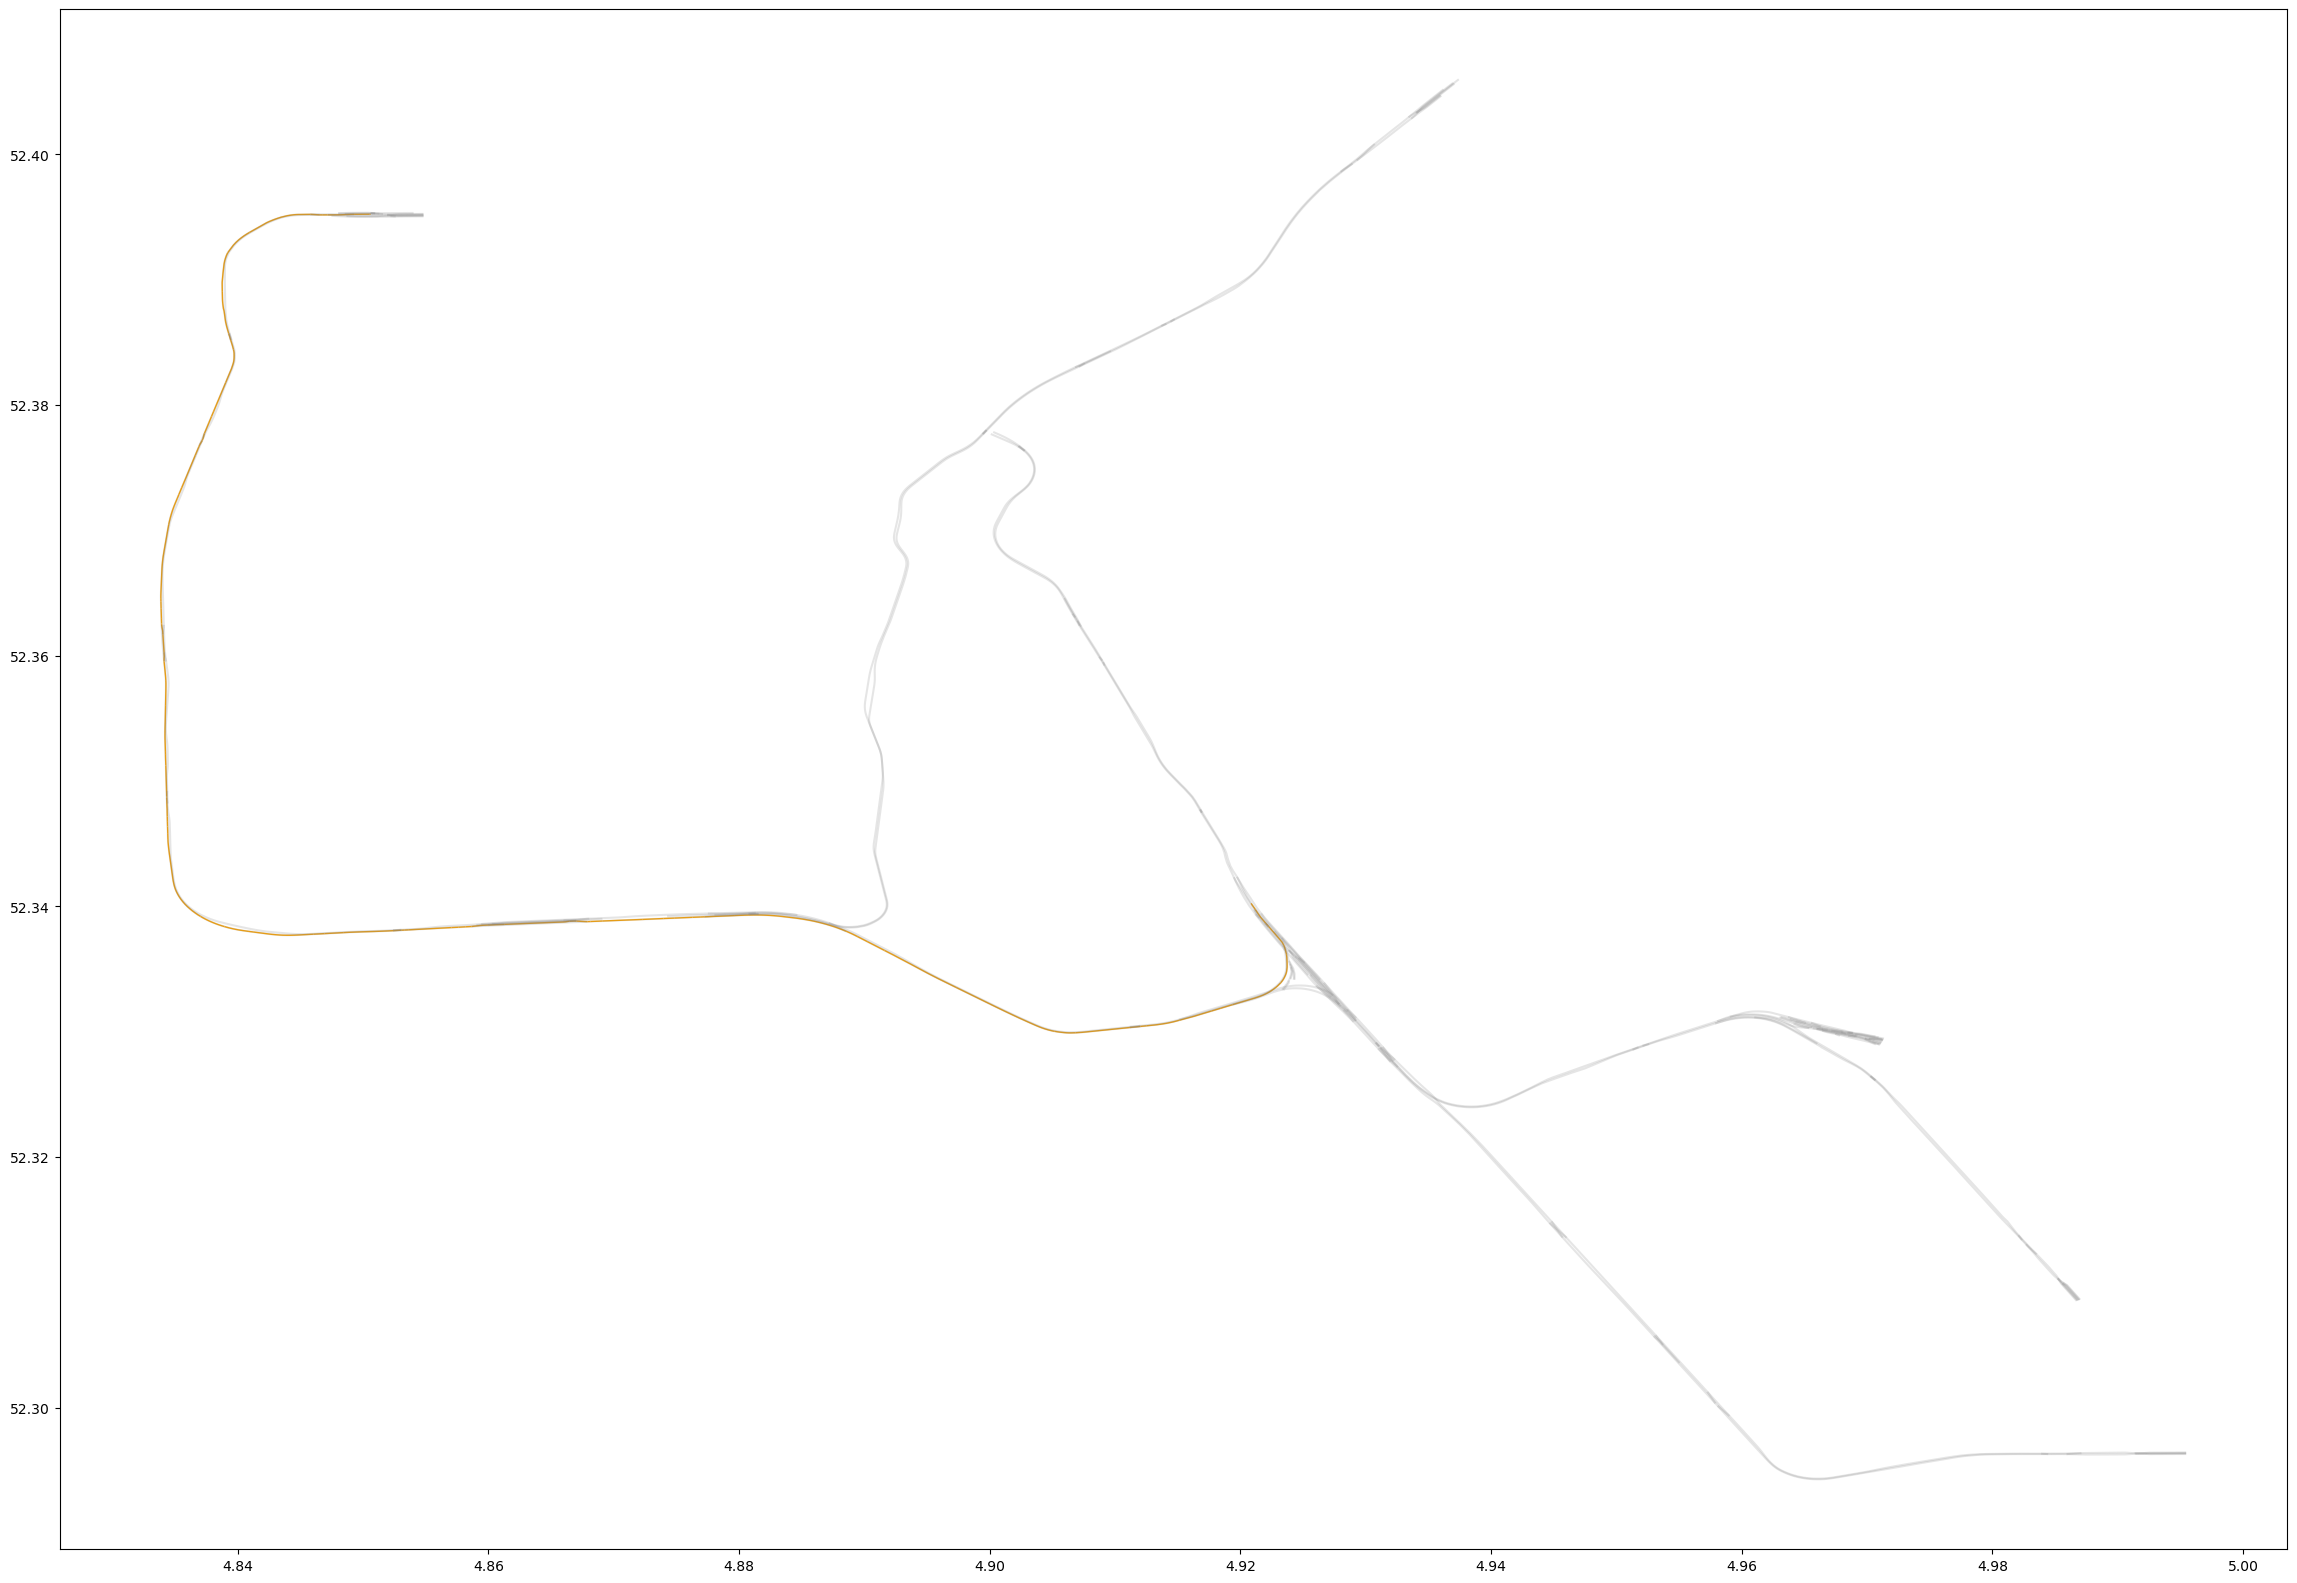

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)

gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [63]:
gpd.GeoDataFrame(shortest_path_edges_way[['osm_id', 'geometry','id']]).to_file('shortest_path_edges_way.GPKG',driver='GPKG')

### Find transfer stations--test_OD_metro_new

In [93]:
t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)

In [94]:
t_station_node

geometry  degree   id  name     geo_x      geo_y  \
62  POINT (4.87723 52.33932)       3  180  Zuid  4.877233  52.339318   

           coordinate_value          route_name_list   route         ref  \
62  (4.8772326, 52.3393181)  Metro 52: Noord => Zuid  subway  50, 51, 52   

      transfer  
62  50, 51, 52

In [95]:
s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
s_t_same_routes_df

s_node and e_node are on same route/routes:   ref
0  52



ref
0  52

In [96]:
all_btw_stations_on_same_route_gdf_s_t = all_stations_on_same_route_gdf_transfer(s_t_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

id              name                  geometry     geo_x      geo_y  \
0  2             Noord  POINT (4.93240 52.40216)  4.932402  52.402157   
1  3       Noorderpark  POINT (4.91811 52.38870)  4.918111  52.388698   
2  1  Centraal Station  POINT (4.90088 52.37921)  4.900879  52.379208   
3  0             Rokin  POINT (4.89256 52.37054)  4.892564  52.370539   
4  6      Vijzelgracht  POINT (4.89105 52.36069)  4.891047  52.360687   
5  8           De Pijp  POINT (4.89065 52.35396)  4.890648  52.353958   
6  5       Europaplein  POINT (4.89156 52.34118)   4.89156  52.341178   
7  4              Zuid  POINT (4.87723 52.33932)  4.877233  52.339318   

           route_name_list ref   route         coordinate_value  order_index  
0  Metro 52: Noord => Zuid  52  subway   (4.932402, 52.4021571)            0  
1  Metro 52: Noord => Zuid  52  subway  (4.9181114, 52.3886982)            1  
2  Metro 52: Noord => Zuid  52  subway  (4.9008785, 52.3792082)            2  
3  Metro 52: Noord => Zuid  52  subway  (4.8925639, 52.3705391)            3  
4  Metro 52: Noord => Zuid  52  subway  (4.8910469, 52.3606866)            4  
5  Metro 52: Noord => Zuid  52  subway  (4.8906476, 52.3539585)            5  
6  Metro 52: Noord => Zuid  52  subway  (4.8915605, 52.3411785)            6  
7  Metro 52: Noord => Zuid  52  subway  (4.8772326, 52.3393181)            7

In [97]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

[  s_id e_id
 0  630  818
 1  818  816
 2  816  813
 3  813  861
 4  861  863
 5  863  860
 6  860  180]

In [98]:
t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
t_e_same_routes_df

s_node and e_node are on same route/routes:   ref
0  50



ref
0  50

In [99]:
all_btw_stations_on_same_route_gdf_t_e = all_stations_on_same_route_gdf_transfer(t_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,t_station_node,end_node)
all_btw_stations_on_same_route_gdf_t_e

id             name                  geometry     geo_x      geo_y  \
9    0             Zuid  POINT (4.87398 52.33904)  4.873978  52.339035   
10  19      Station RAI  POINT (4.88942 52.33761)   4.88942  52.337606   
11   9       Overamstel  POINT (4.91770 52.33166)  4.917703   52.33166   
12   7  Van der Madeweg  POINT (4.93007 52.32965)  4.930074  52.329655   
13  15     Duivendrecht  POINT (4.93646 52.32356)  4.936458  52.323565   
14  18      Strandvliet  POINT (4.94142 52.31836)   4.94142  52.318362   

                  route_name_list ref   route         coordinate_value  \
9   Metro 50: Isolatorweg => Gein  50  subway  (4.8739781, 52.3390351)   
10  Metro 50: Isolatorweg => Gein  50  subway  (4.8894203, 52.3376062)   
11  Metro 50: Isolatorweg => Gein  50  subway  (4.9177027, 52.3316595)   
12  Metro 50: Isolatorweg => Gein  50  subway  (4.9300743, 52.3296548)   
13  Metro 50: Isolatorweg => Gein  50  subway   (4.936458, 52.3235649)   
14  Metro 50: Isolatorweg => Gein  50  subway  (4.9414198, 52.3183621)   

    order_index  
9             9  
10           10  
11           11  
12           12  
13           13  
14           14

In [100]:
btw_all_id_pairs_list_t_e = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_t_e,city_sub_new_nodes)
btw_all_id_pairs_list_t_e

[  s_id e_id
 0   83  858
 1  858  836
 2  836  825
 3  825  851
 4  851  856]

All dataframes in the list are the same
All dataframes in the list are the same


<Axes: >

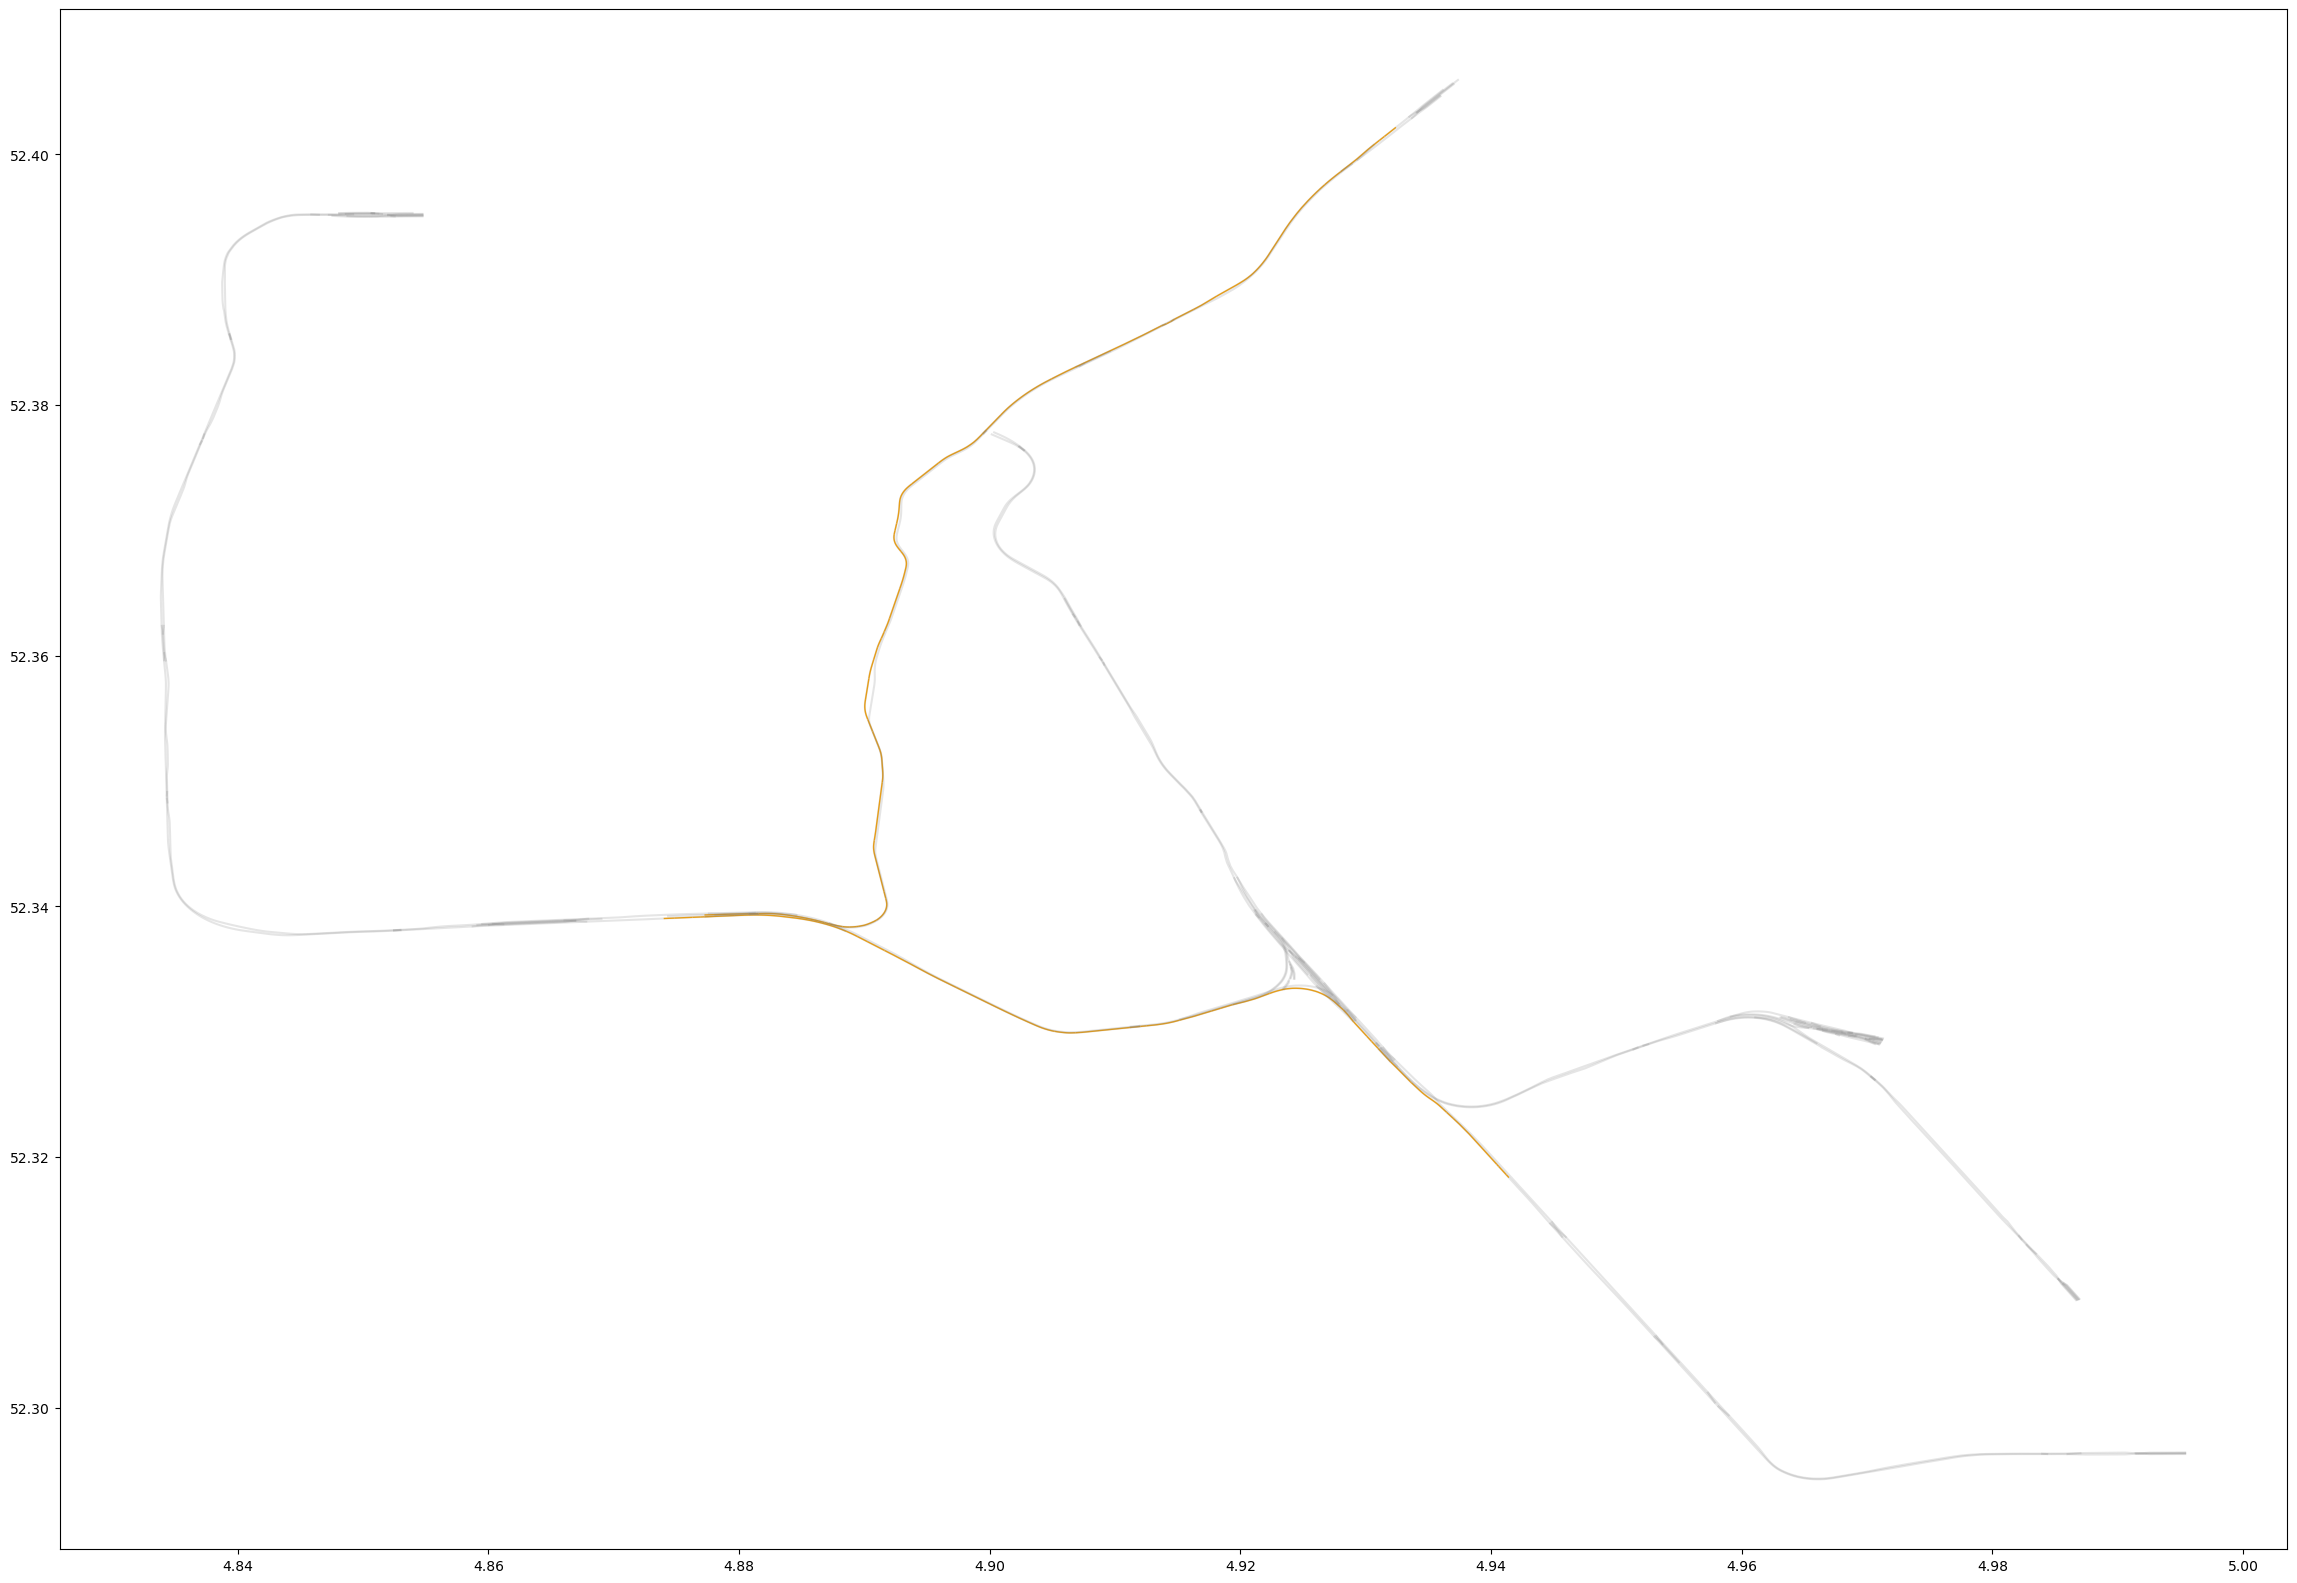

In [101]:
btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])


fig, ax = plt.subplots(1, 1, figsize=(30, 20))
gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [102]:
shortest_path_edges_way

osm_id                                           geometry railway  \
0   136788201  LINESTRING (4.9311003 52.4011329, 4.930722 52....  subway   
1   136788201  LINESTRING (4.930722 52.4008341, 4.930172 52.4...  subway   
2   397809117  LINESTRING (4.926275 52.3971789, 4.9260716 52....  subway   
3   397809131  LINESTRING (4.9267355 52.3975935, 4.9264532 52...  subway   
4   519100601  LINESTRING (4.932402 52.4021571, 4.9314884 52....  subway   
..        ...                                                ...     ...   
33  166130759  LINESTRING (4.9369703 52.3230921, 4.9374703 52...  subway   
34  166130761  LINESTRING (4.936458 52.3235649, 4.9369703 52....  subway   
35  181254574  LINESTRING (4.9406044 52.319253, 4.9412151 52....  subway   
36  181254575  LINESTRING (4.940456 52.3194185, 4.9406044 52....  subway   
37  181255225  LINESTRING (4.9412151 52.3185867, 4.9414198 52...  subway   

   service   id  from_id  to_id     distance      time  weights     to_from  \
0     None  188      172    641    42.045134  0.001682       42  (172, 641)   
1     None  189      641    173   309.423293  0.012377      309  (641, 173)   
2     None  683      621    818  1108.588537  0.044344     1108  (621, 818)   
3     None  689      628    621    55.767621  0.002231       55  (628, 621)   
4     None  811      630    717   101.564774  0.004063      101  (630, 717)   
..     ...  ...      ...    ...          ...       ...      ...         ...   
33    None  242      220    221   472.905913  0.018916      472  (220, 221)   
34    None  244      851    220    63.138124  0.002526       63  (851, 220)   
35    None  463      397    398    85.020091  0.003401       85  (397, 398)   
36    None  464      221    397    21.008884  0.000840       21  (221, 397)   
37    None  468      398    856    28.620520  0.001145       28  (398, 856)   

       from_to                route_name_list   route     ref  count_weight  
0   (641, 172)        Metro 52: Noord => Zuid  subway      52           1.0  
1   (173, 641)        Metro 52: Noord => Zuid  subway      52           1.0  
2   (818, 621)        Metro 52: Noord => Zuid  subway      52           1.0  
3   (621, 628)        Metro 52: Noord => Zuid  subway      52           1.0  
4   (717, 630)        Metro 52: Noord => Zuid  subway      52           1.0  
..         ...                            ...     ...     ...           ...  
33  (221, 220)  Metro 50: Isolatorweg => Gein  subway  50, 54           1.0  
34  (220, 851)  Metro 50: Isolatorweg => Gein  subway  50, 54           1.0  
35  (398, 397)  Metro 50: Isolatorweg => Gein  subway  50, 54           1.0  
36  (397, 221)  Metro 50: Isolatorweg => Gein  subway  50, 54           1.0  
37  (856, 398)  Metro 50: Isolatorweg => Gein  subway  50, 54           1.0  

[89 rows x 16 columns]

In [103]:
gpd.GeoDataFrame(shortest_path_edges_way[['osm_id', 'geometry','id']]).to_file('shortest_path_edges_way_transfer.GPKG',driver='GPKG')

# Connet 52 to other three routes

In [ ]:
from shapely.geometry import Point, Polygon, LineString

In [ ]:
central_stations_gdf = gpd.GeoDataFrame(city_sub_stations[city_sub_stations.name == 'Centraal Station'].copy())
central_stations_gdf = central_stations_gdf.reset_index(drop=True)
central_stations_gdf

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[0, 'geometry']]

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[1, 'geometry']]

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[2, 'geometry']]

In [ ]:
nodes[nodes.geometry == central_stations_gdf.loc[3, 'geometry']]

In [ ]:
# 选择两个点
point_a = central_stations_gdf.loc[1, 'geometry']
point_b = central_stations_gdf.loc[3, 'geometry']

# 创建连接这两个点的线
line = LineString([point_a, point_b])

# 创建一个包含线的DataFrame
edges_central1 = gpd.GeoDataFrame({'id': [1], 'geometry': [line]}, geometry='geometry')

In [ ]:
edges_central1

In [ ]:
# 选择两个点
point_a = central_stations_gdf.loc[0, 'geometry']
point_b = central_stations_gdf.loc[2, 'geometry']

# 创建连接这两个点的线
line = LineString([point_a, point_b])

# 创建一个包含线的DataFrame
edges_central2 = gpd.GeoDataFrame({'id': [1], 'geometry': [line]}, geometry='geometry')
edges_central2

In [ ]:
city_sub_new_edges_central = pd.concat([city_sub_new_edges,edges_central1])
city_sub_new_edges_central

In [ ]:
city_sub_new_edges

# Test all OD pairs--former functions, before creating test_OD_metro_new

In [ ]:
def test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict):
    
    for index, row in OD_df.iterrows():
        OD_pair = pd.Series(row)
        start_node, end_node = s_e_node_df(OD_pair, city_sub_new_nodes)
       
        s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)
        s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)
        s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
        if s_e_same_routes_df is None:
            t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)
            s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
            s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
            all_stations_on_matched_routes_dfs_s_t = all_stations_on_matched_routes(s_t_same_routes_df,city_sub_routes,start_node,t_station_node,city_sub_order_route_dict)
            btw_stations_each_way_list_s_t = btw_stations_each_way_list(start_node,t_station_node,all_stations_on_matched_routes_dfs_s_t)
        
            t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
            t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
            all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
            btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)
        
            btw_all_id_pairs_list_s_t = btw_all_ids_pairs(btw_stations_each_way_list_s_t,city_sub_new_nodes)
            btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)
        
            btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
            btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

            G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
            shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
            duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
            shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
            duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
            shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])
        

            fig, ax = plt.subplots(1, 1, figsize=(30, 20))
            gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
            gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
            print(index)
                
        else:
            s_e_on_same_route_gdf = s_e_same_route_gdf_metro(s_e_same_routes_df,city_sub_routes,start_node)
        
            all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node, end_node)
            btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf,city_sub_new_nodes)
            btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)
            G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
            shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)
            duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_nodes)
            fig, ax = plt.subplots(1, 1, figsize=(30, 20))
            gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
            gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
            print(index)

In [ ]:
def test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict):
    
    for index, row in OD_df.iterrows():
        OD_pair = pd.Series(row)
        start_node, end_node = s_e_node_df(OD_pair, city_sub_new_nodes)
       
        s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)
        s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)
        s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
        if s_e_same_routes_df is None:
            t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)
            if  t_station_node.iloc[0][3] == start_node.iloc[0][3]:
                t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
                t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
                all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
                btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)
                
                btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)
                btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)
                G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
                shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
                duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)

                fig, ax = plt.subplots(1, 1, figsize=(30, 20))
                gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
                gpd.GeoDataFrame(shortest_path_edges_way_t_e.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way_t_e.count_weight), color='orange')
                print(index)
                
            else:
                s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
                s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
                all_stations_on_matched_routes_dfs_s_t = all_stations_on_matched_routes(s_t_same_routes_df,city_sub_routes,start_node,t_station_node,city_sub_order_route_dict)
                btw_stations_each_way_list_s_t = btw_stations_each_way_list(start_node,t_station_node,all_stations_on_matched_routes_dfs_s_t)
            
                t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
                t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
                all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
                btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)
            
                btw_all_id_pairs_list_s_t = btw_all_ids_pairs(btw_stations_each_way_list_s_t,city_sub_new_nodes)
                btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)
            
                btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
                btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

                G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
                shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
                duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
                shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
                duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
                shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])
            

                fig, ax = plt.subplots(1, 1, figsize=(30, 20))
                gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
                gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
                print(index)
                
        else:
            s_e_on_same_route_gdf = s_e_same_route_gdf_metro(s_e_same_routes_df,city_sub_routes,start_node)
        
            all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node, end_node)
            btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf,city_sub_new_nodes)
            btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)
            G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
            shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)
            duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_nodes)
            fig, ax = plt.subplots(1, 1, figsize=(30, 20))
            gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
            gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')
            print(index)

In [ ]:
test_OD_metro(OD_df,city_sub_new_nodes,city_sub_new_edges,city_sub_routes,city_sub_order_route_dict)

# Test 1:--The Former one, before creating test_OD_metro_new

In [60]:
start_node, end_node = s_e_node_df(OD_df.iloc[48], city_sub_new_nodes)

In [61]:
start_node

geometry  degree   id  name     geo_x      geo_y  \
0  POINT (4.98916 52.29641)       2  328  Gein  4.989161  52.296407   

          coordinate_value                route_name_list   route     ref  \
0  (4.9891612, 52.2964067)  Metro 50: Gein => Isolatorweg  subway  50, 54   

  transfer  
0   50, 54

In [62]:
end_node

geometry  degree   id        name     geo_x      geo_y  \
53  POINT (4.90108 52.37135)       2  866  Nieuwmarkt  4.901085  52.371353   

          coordinate_value                            route_name_list   route  \
53  (4.9010846, 52.371353)  Metro 51: Isolatorweg => Centraal Station  subway   

           ref    transfer  
53  51, 53, 54  51, 53, 54

In [63]:
sub_routes_gdf = gpd.GeoDataFrame(city_sub_routes.copy())
s_node_gdf = gpd.GeoDataFrame(start_node.copy())
e_node_gdf = gpd.GeoDataFrame(end_node.copy())

In [64]:
s_node_on_route_gdf = sub_routes_gdf[sub_routes_gdf.geometry.intersects(s_node_gdf.iloc[0].geometry)]
s_node_on_route_gdf

osm_id   route                to                                name ref  \
0    18683  subway       Isolatorweg       Metro 50: Gein => Isolatorweg  50   
9  4515357  subway  Centraal Station  Metro 54: Gein => Centraal Station  54   

                  network service  \
0  Stadsvervoer Amsterdam    None   
9  Stadsvervoer Amsterdam    None   

                                            geometry  
0  MULTILINESTRING ((4.98996 52.29640, 4.98959 52...  
9  MULTILINESTRING ((4.98996 52.29640, 4.98959 52...

In [65]:
e_node_on_route_gdf = sub_routes_gdf[sub_routes_gdf.geometry.intersects(e_node_gdf.iloc[0].geometry)]
e_node_on_route_gdf

osm_id   route                to  \
3  4515355  subway  Centraal Station   
7  4515356  subway  Centraal Station   
9  4515357  subway  Centraal Station   

                                        name ref                 network  \
3  Metro 51: Isolatorweg => Centraal Station  51  Stadsvervoer Amsterdam   
7  Metro 53: Gaasperplas => Centraal Station  53  Stadsvervoer Amsterdam   
9         Metro 54: Gein => Centraal Station  54  Stadsvervoer Amsterdam   

  service                                           geometry  
3    None  MULTILINESTRING ((4.83880 52.38842, 4.83897 52...  
7    None  MULTILINESTRING ((4.98373 52.31201, 4.98364 52...  
9    None  MULTILINESTRING ((4.98996 52.29640, 4.98959 52...

### Find the route which the s_e nodes are on----compare with new_edges instead of routes dataframe, should compare with routes dataframe

In [66]:
s_on_route_ref,e_on_route_ref = s_e_on_route_ref(start_node, end_node)

### Make judgement of s_e_on_route_ref

In [67]:
s_on_route_ref, e_on_route_ref = judge_on_route(s_on_route_ref, e_on_route_ref)

Some of e_on_route is the same as some of s_on_route.
The next step is to find the same routes ---- using function 's_e_same_routes'


In [68]:
s_on_route_ref

ref
0  50
1  54

In [69]:
e_on_route_ref

ref
0  51
1  53
2  54

### Find those same routes

In [70]:
s_e_same_routes_df = s_e_same_routes(s_on_route_ref,e_on_route_ref)
s_e_same_routes_df

s_node and e_node are on same route/routes:   ref
1  54



ref
1  54

In [ ]:
# Third way to get all stations between s_e nodes

In [71]:
all_btw_stations_on_same_route_gdf_s_e = all_stations_on_same_route_gdf_transfer(s_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,end_node)
all_btw_stations_on_same_route_gdf_s_e

id             name                  geometry     geo_x      geo_y  \
0    4             Gein  POINT (4.98916 52.29641)  4.989161  52.296407   
1   11       Reigersbos  POINT (4.97400 52.29564)     4.974  52.295637   
2   10      Holendrecht  POINT (4.96013 52.29813)  4.960126  52.298132   
3    5        Bullewijk  POINT (4.95213 52.30687)  4.952129  52.306869   
4    3    Bijlmer ArenA  POINT (4.94762 52.31181)  4.947618  52.311806   
5    2      Strandvliet  POINT (4.94140 52.31861)  4.941398  52.318612   
6    9     Duivendrecht  POINT (4.93656 52.32360)   4.93656  52.323602   
7    7  Van der Madeweg  POINT (4.93045 52.32978)  4.930454  52.329785   
8    8       Spaklerweg  POINT (4.92105 52.34029)  4.921045  52.340287   
9    6    Amstelstation  POINT (4.91748 52.34665)  4.917477  52.346648   
10   0     Wibautstraat  POINT (4.91205 52.35459)  4.912049  52.354595   
11  14     Weesperplein  POINT (4.90792 52.36133)  4.907918  52.361326   
12  13    Waterlooplein  POINT (4.90375 52.36669)  4.903753   52.36669   
13  12       Nieuwmarkt  POINT (4.90108 52.37135)  4.901085  52.371353   

                       route_name_list ref   route         coordinate_value  
0   Metro 54: Gein => Centraal Station  54  subway  (4.9891612, 52.2964067)  
1   Metro 54: Gein => Centraal Station  54  subway  (4.9740002, 52.2956365)  
2   Metro 54: Gein => Centraal Station  54  subway  (4.9601264, 52.2981319)  
3   Metro 54: Gein => Centraal Station  54  subway   (4.9521292, 52.306869)  
4   Metro 54: Gein => Centraal Station  54  subway   (4.9476178, 52.311806)  
5   Metro 54: Gein => Centraal Station  54  subway  (4.9413977, 52.3186119)  
6   Metro 54: Gein => Centraal Station  54  subway  (4.9365601, 52.3236024)  
7   Metro 54: Gein => Centraal Station  54  subway  (4.9304544, 52.3297847)  
8   Metro 54: Gein => Centraal Station  54  subway  (4.9210454, 52.3402871)  
9   Metro 54: Gein => Centraal Station  54  subway  (4.9174767, 52.3466483)  
10  Metro 54: Gein => Centraal Station  54  subway  (4.9120486, 52.3545947)  
11  Metro 54: Gein => Centraal Station  54  subway  (4.9079182, 52.3613263)  
12  Metro 54: Gein => Centraal Station  54  subway  (4.9037527, 52.3666905)  
13  Metro 54: Gein => Centraal Station  54  subway   (4.9010846, 52.371353)

#### Get all stations between s_e nodes--- Second way:A route gdf

In [ ]:
s_e_on_same_route_gdf = s_e_same_route_gdf_metro(s_e_same_routes_df,city_sub_routes,start_node)

In [ ]:
s_e_on_same_route_gdf

In [ ]:
all_btw_stations_on_same_route_gdf = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_e_on_same_route_gdf, start_node,end_node)
all_btw_stations_on_same_route_gdf

#### Get all stations' id_pairs between s_e nodes

In [72]:
btw_all_id_pairs_list = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_e,city_sub_new_nodes)
btw_all_id_pairs_list

[   s_id e_id
 0   328  855
 1   855  854
 2   854  810
 3   810  809
 4   809  808
 5   808  852
 6   852  828
 7   828  820
 8   820  139
 9   139  138
 10  138  137
 11  137  866
 12  866  833]

#### Calculate shortest path and plot

In [73]:
btw_all_id_pairs_list_unique = drop_df_in_list(btw_all_id_pairs_list)

All dataframes in the list are the same


In [74]:
G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)

In [75]:
shortest_path_pairs_way = all_shortest_paths(G, btw_all_id_pairs_list_unique[0], city_sub_new_edges)

In [76]:
shortest_path_pairs_way

osm_id                                           geometry railway  \
358   166187911  LINESTRING (4.9823107 52.2963387, 4.9838859 52...  subway   
362   166187914  LINESTRING (4.9850607 52.2963027, 4.9855227 52...  subway   
367   166187917  LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway   
368   166187918  LINESTRING (4.9776921 52.2962066, 4.9783293 52...  subway   
372   166187922  LINESTRING (4.9847395 52.2963009, 4.9850607 52...  subway   
..          ...                                                ...     ...   
544   324074890  LINESTRING (4.9210454 52.3402871, 4.9207679 52...  subway   
545   324074895  LINESTRING (4.9197172 52.3423576, 4.91964 52.3...  subway   
832   562757374  LINESTRING (4.9010846 52.371353, 4.9010385 52....  subway   
948  1131538381  LINESTRING (4.9200955 52.3417374, 4.9200444 52...  subway   
949  1131538382  LINESTRING (4.9201445 52.3416568, 4.9200955 52...  subway   

    service   id  from_id  to_id    distance      time  weights     to_from  \
358    None  358      317    634  107.447350  0.004298      107  (317, 634)   
362    None  362      322    655   57.734405  0.002309       57  (322, 655)   
367    None  367      654    328  140.227871  0.005609      140  (654, 328)   
368    None  368      329    330  272.415707  0.010897      272  (329, 330)   
372    None  372      336    322   21.910518  0.000876       21  (336, 322)   
..      ...  ...      ...    ...         ...       ...      ...         ...   
544    None  544      833    462  164.290754  0.006572      164  (833, 462)   
545    None  545      463    252   15.442083  0.000618       15  (463, 252)   
832    None  833      866    137  609.918310  0.024397      609  (866, 137)   
948    None  957      803    463   73.656989  0.002946       73  (803, 463)   
949    None  958      462    803    9.568427  0.000383        9  (462, 803)   

        from_to                            route_name_list   route         ref  
358  (634, 317)              Metro 50: Gein => Isolatorweg  subway      50, 54  
362  (655, 322)              Metro 50: Gein => Isolatorweg  subway      50, 54  
367  (328, 654)              Metro 50: Gein => Isolatorweg  subway      50, 54  
368  (330, 329)              Metro 50: Gein => Isolatorweg  subway      50, 54  
372  (322, 336)              Metro 50: Gein => Isolatorweg  subway      50, 54  
..          ...                                        ...     ...         ...  
544  (462, 833)  Metro 53: Gaasperplas => Centraal Station  subway      53, 54  
545  (252, 463)  Metro 51: Isolatorweg => Centraal Station  subway  51, 53, 54  
832  (137, 866)  Metro 51: Isolatorweg => Centraal Station  subway  51, 53, 54  
948  (463, 803)  Metro 53: Gaasperplas => Centraal Station  subway      53, 54  
949  (803, 462)  Metro 53: Gaasperplas => Centraal Station  subway      53, 54  

[120 rows x 15 columns]

In [77]:
duplicate_row_count_way, shortest_path_edges_way, edges_way = edges_with_count_weight(shortest_path_pairs_way, city_sub_new_edges)

In [78]:
shortest_path_edges_way

osm_id                                           geometry railway  \
0     166187911  LINESTRING (4.9823107 52.2963387, 4.9838859 52...  subway   
1     166187914  LINESTRING (4.9850607 52.2963027, 4.9855227 52...  subway   
2     166187917  LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway   
3     166187918  LINESTRING (4.9776921 52.2962066, 4.9783293 52...  subway   
4     166187922  LINESTRING (4.9847395 52.2963009, 4.9850607 52...  subway   
..          ...                                                ...     ...   
115   324074890  LINESTRING (4.9210454 52.3402871, 4.9207679 52...  subway   
116   324074895  LINESTRING (4.9197172 52.3423576, 4.91964 52.3...  subway   
117   562757374  LINESTRING (4.9010846 52.371353, 4.9010385 52....  subway   
118  1131538381  LINESTRING (4.9200955 52.3417374, 4.9200444 52...  subway   
119  1131538382  LINESTRING (4.9201445 52.3416568, 4.9200955 52...  subway   

    service   id  from_id  to_id    distance      time  weights     to_from  \
0      None  358      317    634  107.447350  0.004298      107  (317, 634)   
1      None  362      322    655   57.734405  0.002309       57  (322, 655)   
2      None  367      654    328  140.227871  0.005609      140  (654, 328)   
3      None  368      329    330  272.415707  0.010897      272  (329, 330)   
4      None  372      336    322   21.910518  0.000876       21  (336, 322)   
..      ...  ...      ...    ...         ...       ...      ...         ...   
115    None  544      833    462  164.290754  0.006572      164  (833, 462)   
116    None  545      463    252   15.442083  0.000618       15  (463, 252)   
117    None  833      866    137  609.918310  0.024397      609  (866, 137)   
118    None  957      803    463   73.656989  0.002946       73  (803, 463)   
119    None  958      462    803    9.568427  0.000383        9  (462, 803)   

        from_to                            route_name_list   route  \
0    (634, 317)              Metro 50: Gein => Isolatorweg  subway   
1    (655, 322)              Metro 50: Gein => Isolatorweg  subway   
2    (328, 654)              Metro 50: Gein => Isolatorweg  subway   
3    (330, 329)              Metro 50: Gein => Isolatorweg  subway   
4    (322, 336)              Metro 50: Gein => Isolatorweg  subway   
..          ...                                        ...     ...   
115  (462, 833)  Metro 53: Gaasperplas => Centraal Station  subway   
116  (252, 463)  Metro 51: Isolatorweg => Centraal Station  subway   
117  (137, 866)  Metro 51: Isolatorweg => Centraal Station  subway   
118  (463, 803)  Metro 53: Gaasperplas => Centraal Station  subway   
119  (803, 462)  Metro 53: Gaasperplas => Centraal Station  subway   

            ref  count_weight  
0        50, 54           1.0  
1        50, 54           1.0  
2        50, 54           1.0  
3        50, 54           1.0  
4        50, 54           1.0  
..          ...           ...  
115      53, 54           2.0  
116  51, 53, 54           2.0  
117  51, 53, 54           2.0  
118      53, 54           2.0  
119      53, 54           2.0  

[120 rows x 16 columns]

In [79]:
shortest_path_edges_way.time.sum()

0.6083615067292956

<Axes: >

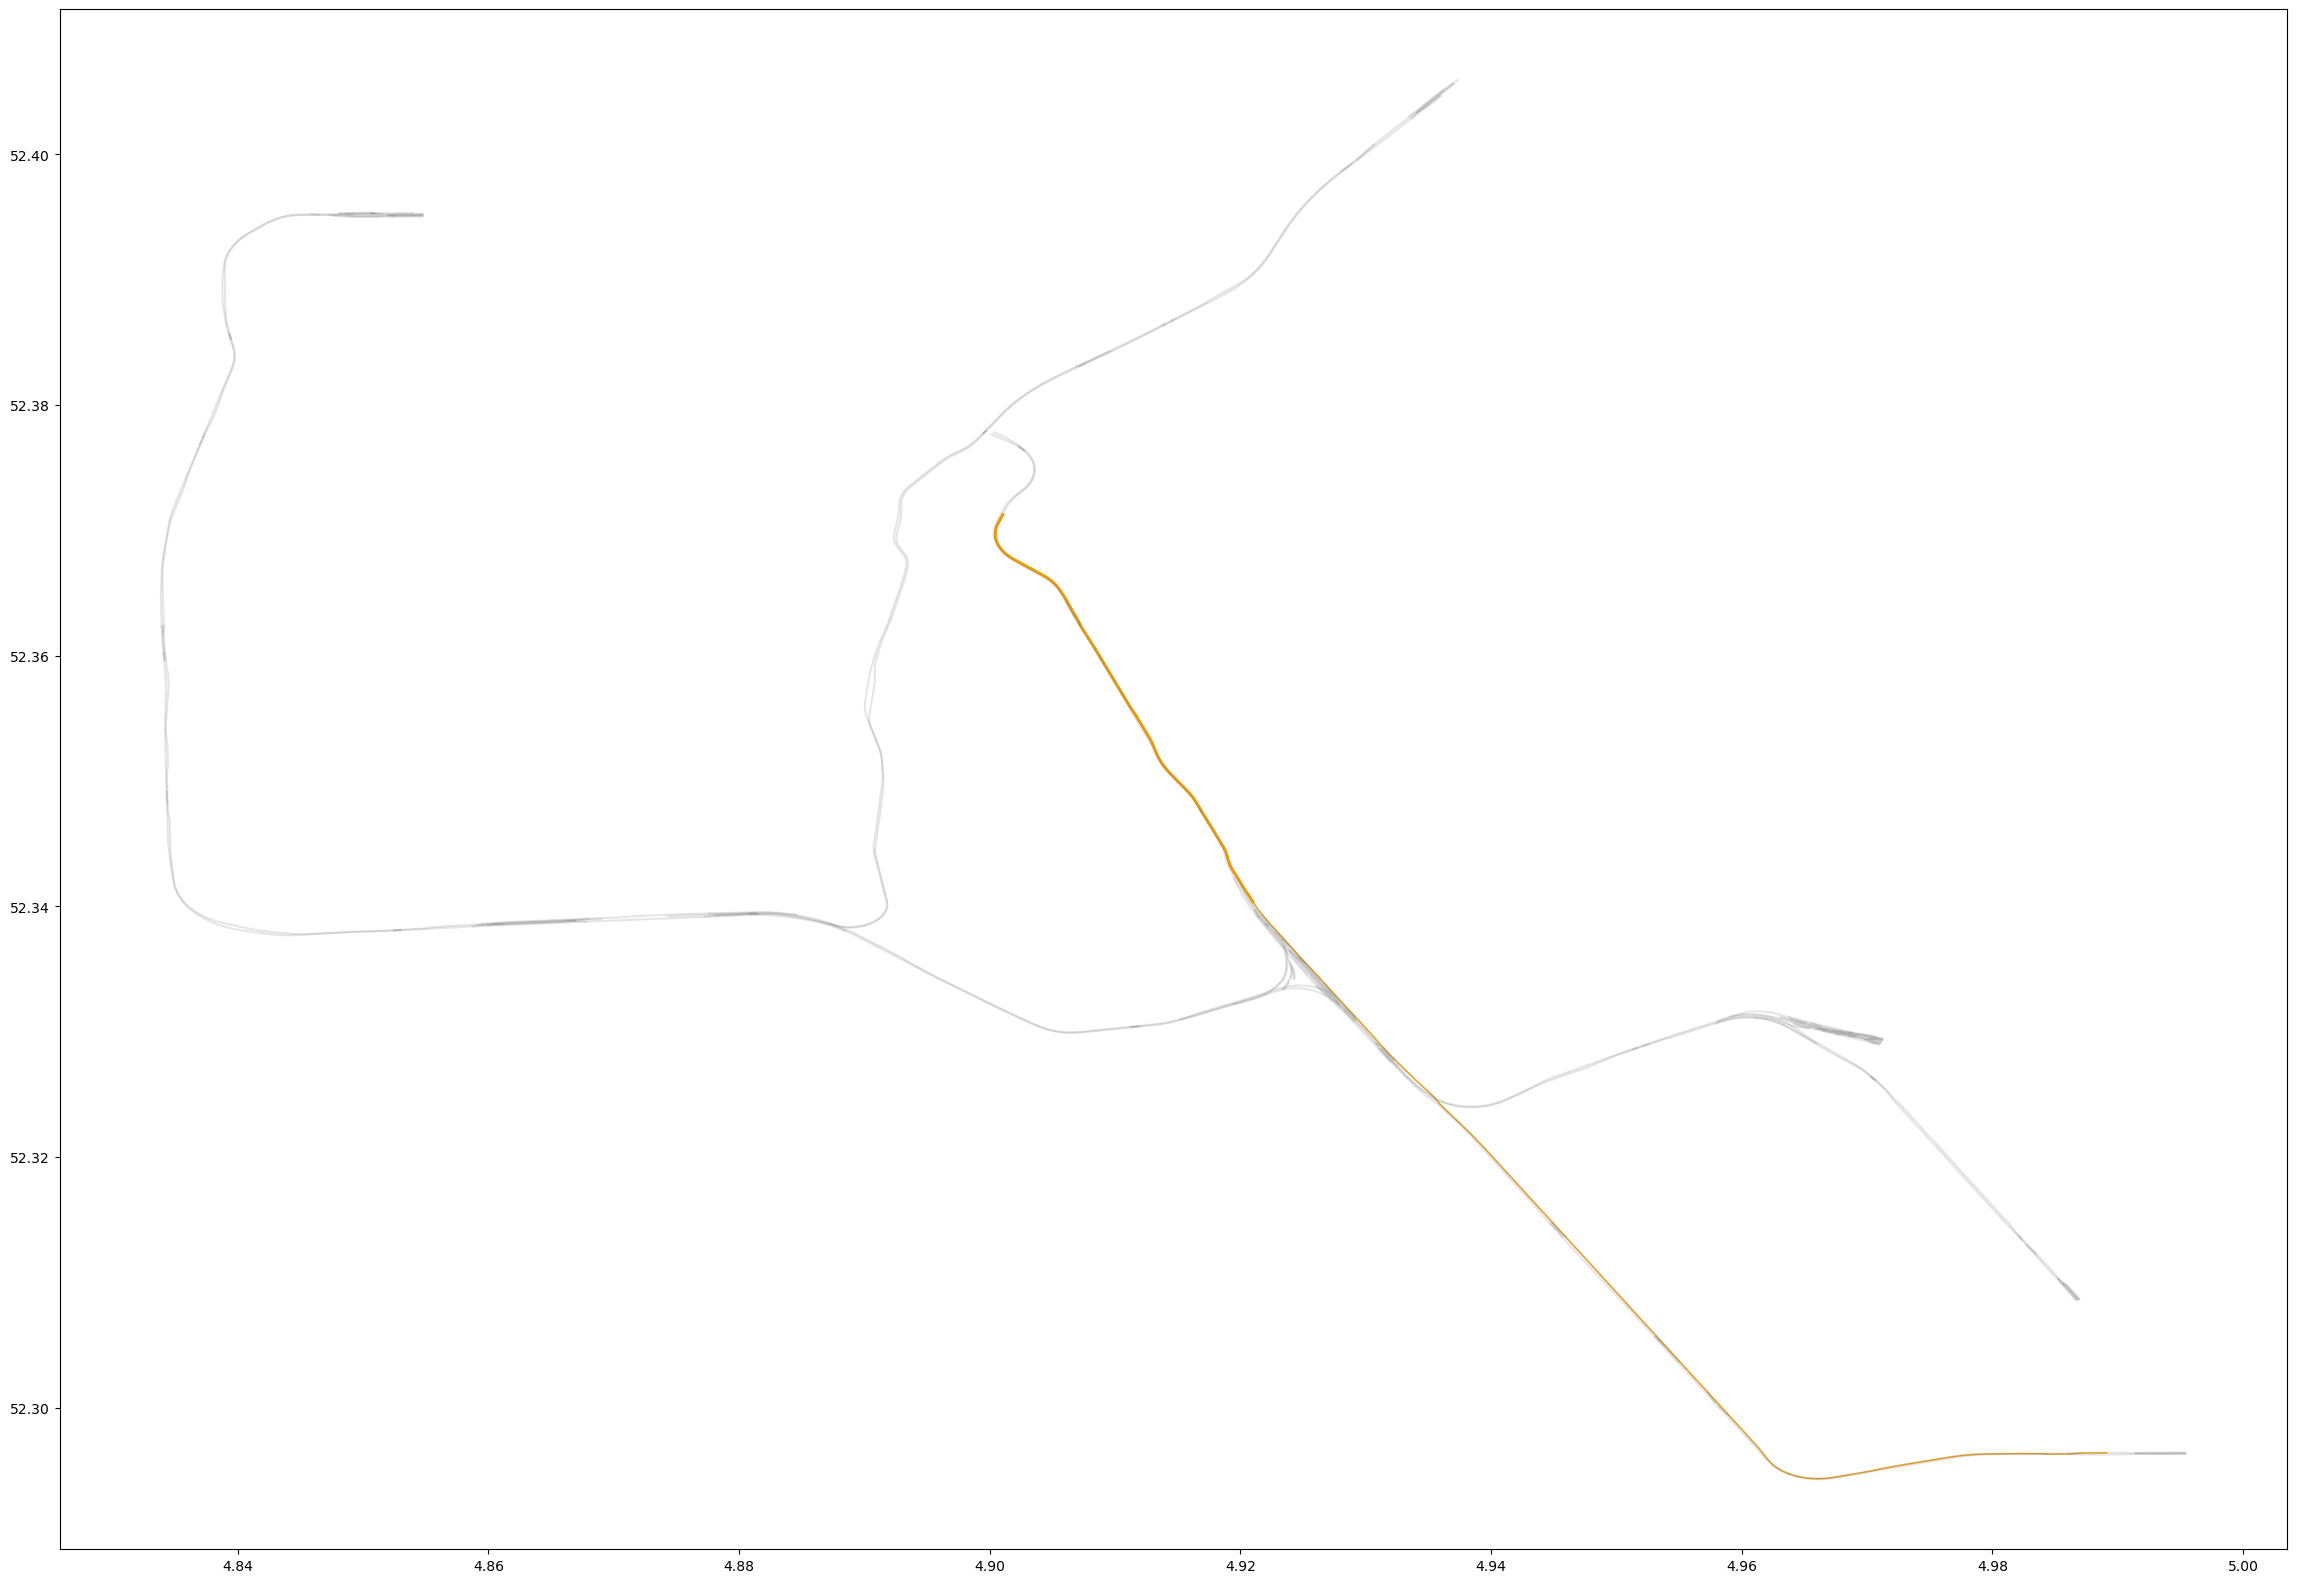

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)

gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [ ]:
gpd.GeoDataFrame(shortest_path_edges_way[['osm_id', 'geometry','id']]).to_file('shortest_path_edges_way.GPKG',driver='GPKG')

### Find transfer stations---the process of creating the third way: all_stations_on_same_route_gdf_transfer

In [48]:
t_station_node = transfer_station_one_mode(city_sub_routes, start_node, end_node, city_sub_new_nodes, city_sub_order_route_dict)

In [49]:
t_station_node

geometry  degree   id  name     geo_x      geo_y  \
10  POINT (4.87396 52.33932)       2  840  Zuid  4.873963  52.339322   

           coordinate_value                route_name_list   route  \
10  (4.8739633, 52.3393223)  Metro 50: Gein => Isolatorweg  subway   

           ref    transfer  
10  50, 51, 52  50, 51, 52

In [50]:
s_on_route_ref,t_on_route_ref = s_e_on_route_ref(start_node, t_station_node)
s_t_same_routes_df = s_e_same_routes(s_on_route_ref,t_on_route_ref)
s_t_same_routes_df

s_node and e_node are on same route/routes:   ref
0  50



ref
0  50

In [ ]:
# Third way to get all stations between s_t

In [51]:
all_btw_stations_on_same_route_gdf_s_t = all_stations_on_same_route_gdf_transfer(s_t_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

id             name                  geometry     geo_x      geo_y  \
0    5             Gein  POINT (4.98916 52.29641)  4.989161  52.296407   
1   18       Reigersbos  POINT (4.97400 52.29564)     4.974  52.295637   
2   17      Holendrecht  POINT (4.96013 52.29813)  4.960126  52.298132   
3    6        Bullewijk  POINT (4.95213 52.30687)  4.952129  52.306869   
4    4    Bijlmer ArenA  POINT (4.94762 52.31181)  4.947618  52.311806   
5    3      Strandvliet  POINT (4.94140 52.31861)  4.941398  52.318612   
6   16     Duivendrecht  POINT (4.93656 52.32360)   4.93656  52.323602   
7    7  Van der Madeweg  POINT (4.93045 52.32978)  4.930454  52.329785   
8    9       Overamstel  POINT (4.91761 52.33177)  4.917606  52.331769   
9   19      Station RAI  POINT (4.88954 52.33769)  4.889539  52.337689   
10  10             Zuid  POINT (4.87396 52.33932)  4.873963  52.339322   

                  route_name_list ref   route         coordinate_value  \
0   Metro 50: Gein => Isolatorweg  50  subway  (4.9891612, 52.2964067)   
1   Metro 50: Gein => Isolatorweg  50  subway  (4.9740002, 52.2956365)   
2   Metro 50: Gein => Isolatorweg  50  subway  (4.9601264, 52.2981319)   
3   Metro 50: Gein => Isolatorweg  50  subway   (4.9521292, 52.306869)   
4   Metro 50: Gein => Isolatorweg  50  subway   (4.9476178, 52.311806)   
5   Metro 50: Gein => Isolatorweg  50  subway  (4.9413977, 52.3186119)   
6   Metro 50: Gein => Isolatorweg  50  subway  (4.9365601, 52.3236024)   
7   Metro 50: Gein => Isolatorweg  50  subway  (4.9304544, 52.3297847)   
8   Metro 50: Gein => Isolatorweg  50  subway  (4.9176063, 52.3317688)   
9   Metro 50: Gein => Isolatorweg  50  subway    (4.889539, 52.337689)   
10  Metro 50: Gein => Isolatorweg  50  subway  (4.8739633, 52.3393223)   

    order_index  
0             0  
1             1  
2             2  
3             3  
4             4  
5             5  
6             6  
7             7  
8             8  
9             9  
10           10

In [52]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

[  s_id e_id
 0  328  855
 1  855  854
 2  854  810
 3  810  809
 4  809  808
 5  808  852
 6  852  828
 7  828  838
 8  838  857
 9  857  840]

In [ ]:
# First way to get all stations between s_t

In [ ]:
s_t_on_same_route_gdf = s_e_same_route_gdf_metro(s_t_same_routes_df,city_sub_routes,start_node)
s_t_on_same_route_gdf

In [ ]:
all_btw_stations_on_same_route_gdf_s_t = all_btw_stations_on_same_route_gdf_metro(city_sub_order_route_dict, s_t_on_same_route_gdf, start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

In [ ]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

In [ ]:
# Second way to get all stations between s_t

In [ ]:
all_stations_on_matched_routes_dfs_s_t = all_stations_on_matched_routes(s_t_same_routes_df,city_sub_routes,start_node,t_station_node,city_sub_order_route_dict)
all_stations_on_matched_routes_dfs_s_t

In [ ]:
btw_stations_each_way_list_s_t = btw_stations_each_way_list(start_node,t_station_node,all_stations_on_matched_routes_dfs_s_t)

In [ ]:
btw_stations_each_way_list_s_t

In [ ]:
btw_all_id_pairs_list_s_t = btw_all_ids_pairs(btw_stations_each_way_list_s_t,city_sub_new_nodes)
btw_all_id_pairs_list_s_t

In [53]:
t_on_route_ref,e_on_route_ref = s_e_on_route_ref( t_station_node,end_node)
t_e_same_routes_df = s_e_same_routes(t_on_route_ref,e_on_route_ref)
t_e_same_routes_df

s_node and e_node are on same route/routes:   ref
2  52



ref
2  52

In [54]:
all_btw_stations_on_same_route_gdf_t_e = all_stations_on_same_route_gdf_transfer(t_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,t_station_node,end_node)
all_btw_stations_on_same_route_gdf_t_e

id         name                  geometry     geo_x      geo_y  \
0  3         Zuid  POINT (4.87802 52.33930)  4.878025  52.339303   
1  5  Europaplein  POINT (4.89143 52.34192)   4.89143  52.341922   
2  7      De Pijp  POINT (4.89065 52.35396)  4.890648  52.353958   

           route_name_list ref   route         coordinate_value  
0  Metro 52: Zuid => Noord  52  subway  (4.8780248, 52.3393025)  
1  Metro 52: Zuid => Noord  52  subway  (4.8914299, 52.3419224)  
2  Metro 52: Zuid => Noord  52  subway  (4.8906476, 52.3539585)

In [58]:
btw_all_id_pairs_list_t_e = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_t_e,city_sub_new_nodes)
btw_all_id_pairs_list_t_e

[  s_id e_id
 0  345  859
 1  859  863]

All dataframes in the list are the same
All dataframes in the list are the same


<Axes: >

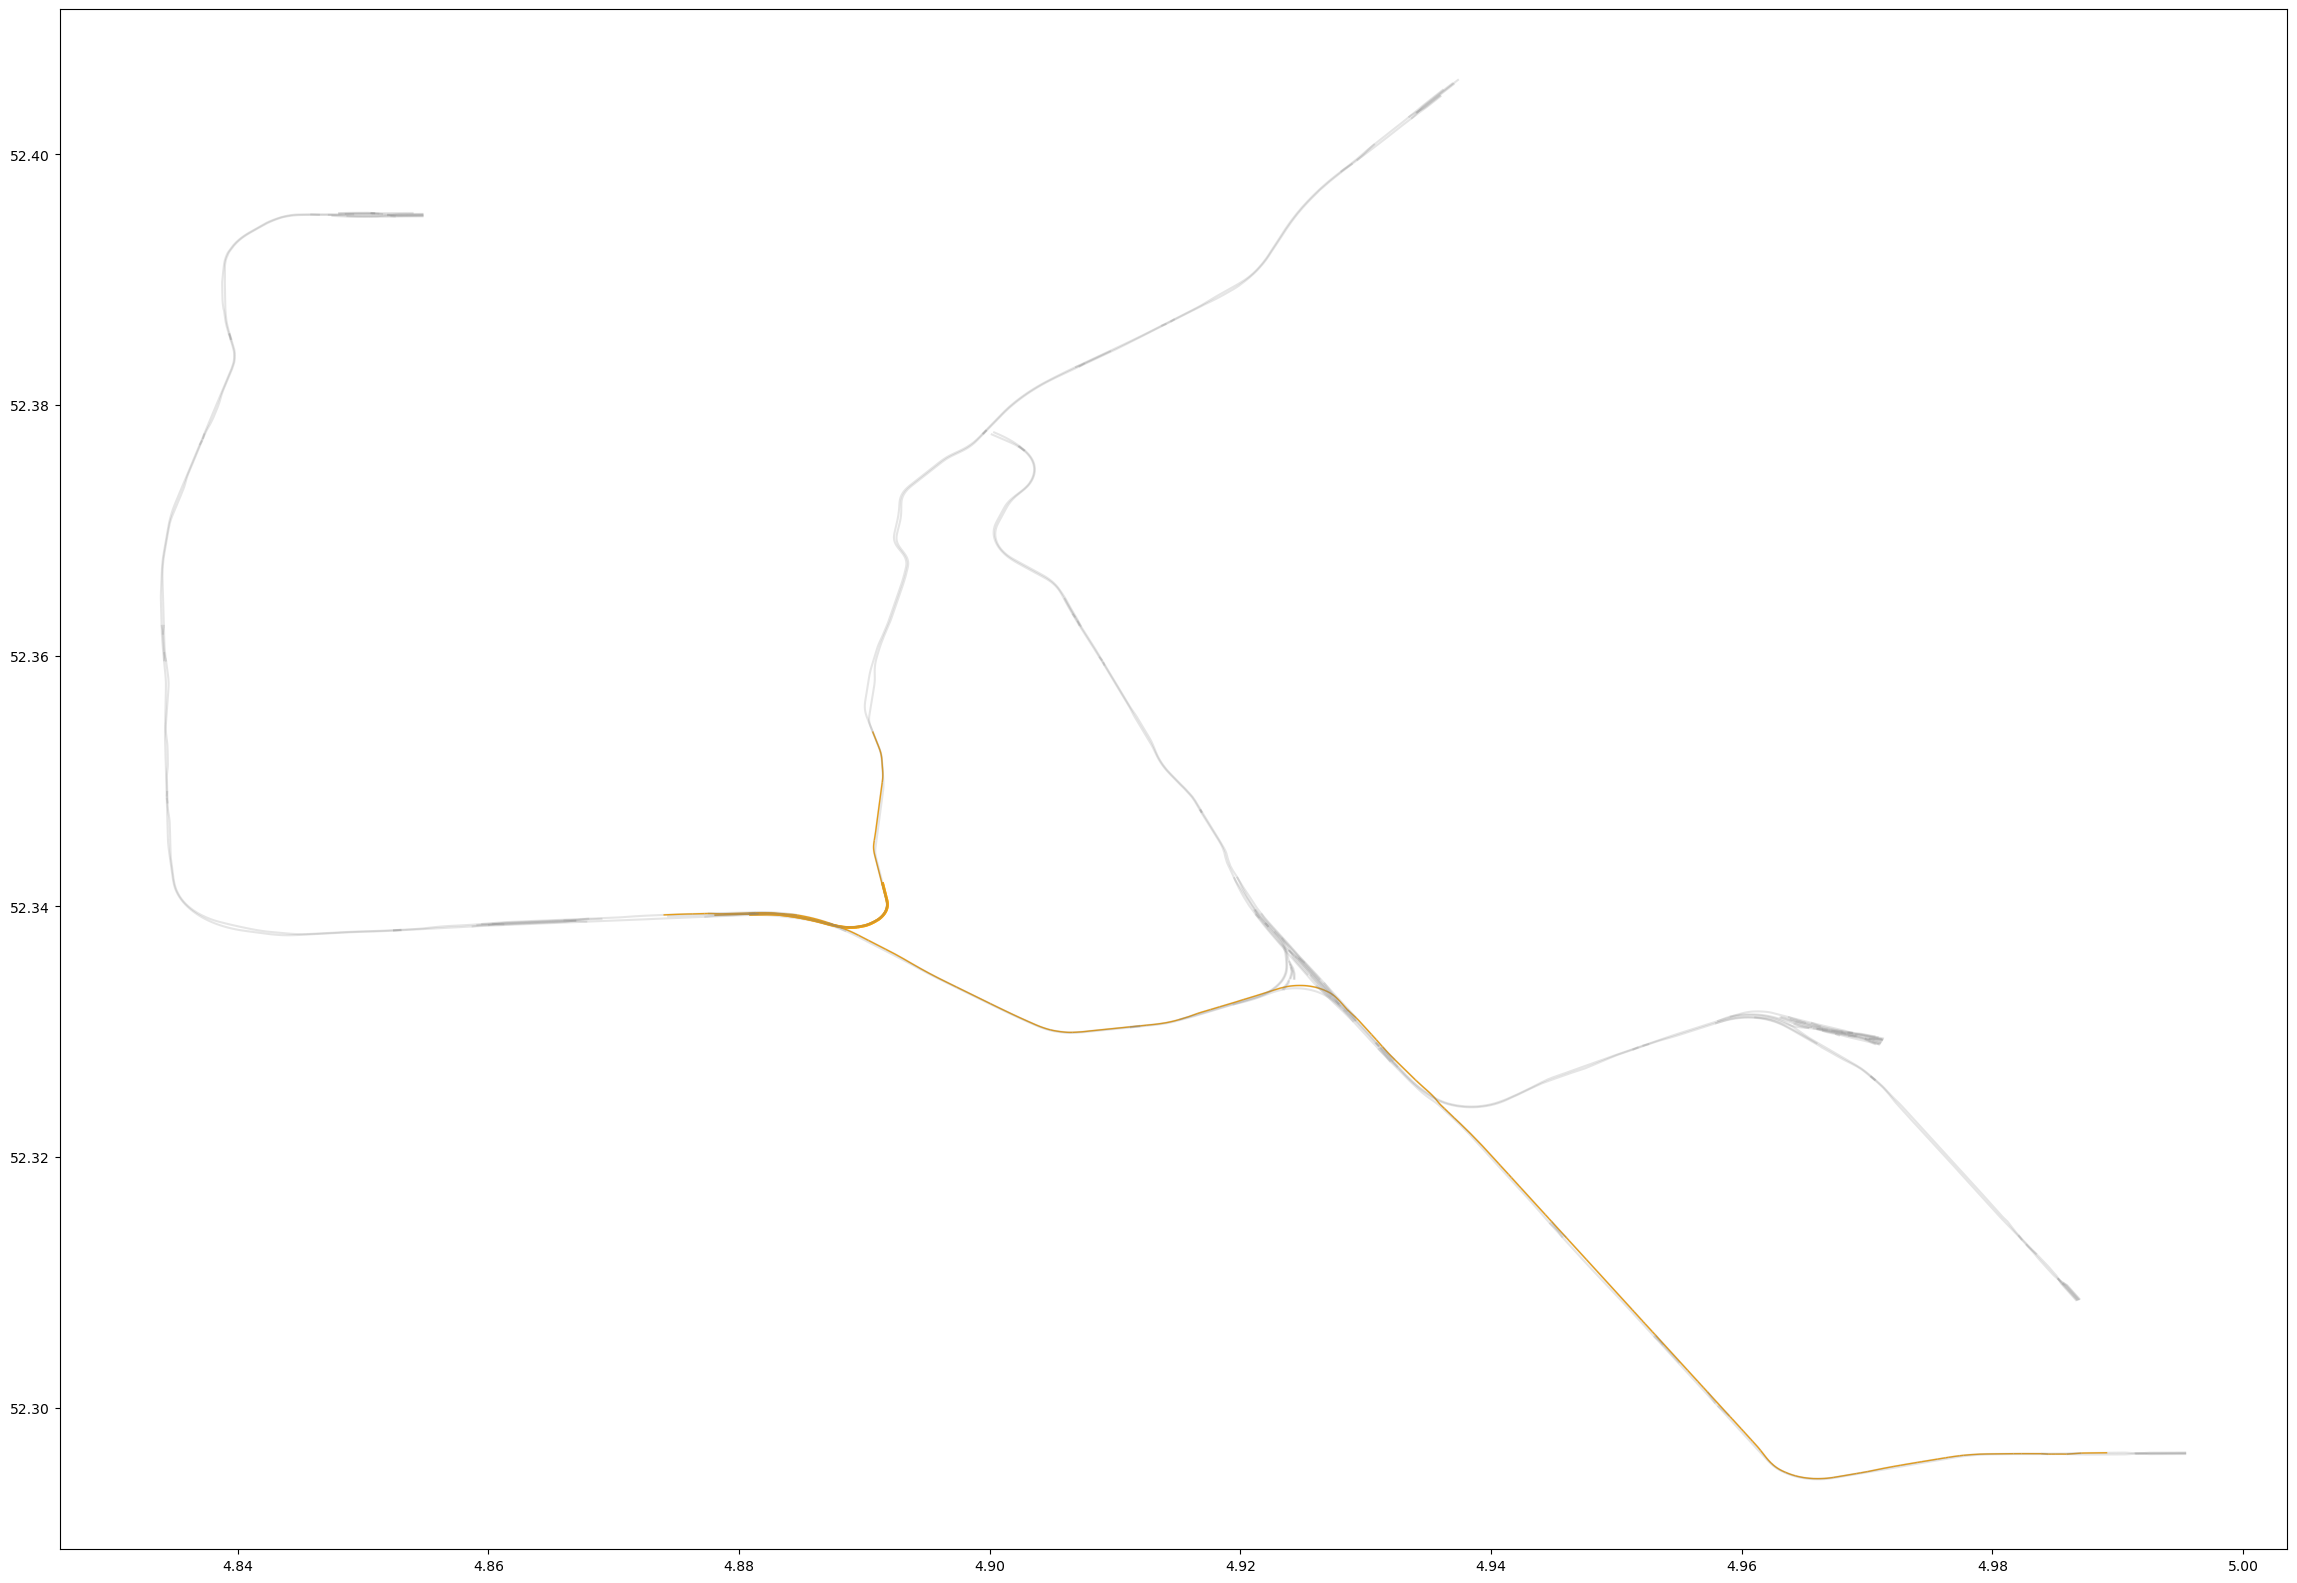

In [59]:
btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])


fig, ax = plt.subplots(1, 1, figsize=(30, 20))
gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')

In [122]:
def all_stations_on_same_route_gdf_transfer(t_e_same_routes_df, city_sub_routes, city_sub_order_route_dict, t_station_node, end_node):
    t_e_on_possible_route_df = pd.merge(t_e_same_routes_df, city_sub_routes, on='ref', how='left')
    t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())
    
    all_btw_stations_on_same_route_gdf_t_e = None  
    
    for i in range(len(t_e_on_route_possible_gdf)):
        all_stations_on_possible_route_t_e = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[i]]
    
        all_stations_on_possible_route_t_e_gdf = gpd.GeoDataFrame(all_stations_on_possible_route_t_e.copy())
    
        t_station_node_gdf = gpd.GeoDataFrame(t_station_node.copy())
        end_node_gdf = gpd.GeoDataFrame(end_node.copy())

        t_station_node_index = shapely.distance(t_station_node_gdf.geometry.values, all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
        end_station_index = shapely.distance(end_node_gdf.geometry.values, all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    
        if t_station_node_index > end_station_index:
            continue  
        else:
            all_btw_stations_on_same_route_gdf_t_e = all_stations_on_possible_route_t_e_gdf.iloc[t_station_node_index:end_station_index+1]
            break
    
    if all_btw_stations_on_same_route_gdf_t_e is None:

        raise ValueError("No suitable stations found.")
    
    return all_btw_stations_on_same_route_gdf_t_e

In [123]:
all_btw_stations_on_same_route_gdf_t_e = all_stations_on_same_route_gdf_transfer(t_e_same_routes_df,city_sub_routes,city_sub_order_route_dict,t_station_node,end_node)
all_btw_stations_on_same_route_gdf_t_e

id              name                  geometry     geo_x      geo_y  \
0  3              Zuid  POINT (4.87802 52.33930)  4.878025  52.339303   
1  5       Europaplein  POINT (4.89143 52.34192)   4.89143  52.341922   
2  7           De Pijp  POINT (4.89065 52.35396)  4.890648  52.353958   
3  6      Vijzelgracht  POINT (4.89122 52.36067)  4.891221  52.360666   
4  9             Rokin  POINT (4.89277 52.37044)  4.892773  52.370443   
5  0  Centraal Station  POINT (4.90094 52.37919)  4.900937  52.379188   
6  2       Noorderpark  POINT (4.91828 52.38859)  4.918276  52.388594   

           route_name_list ref   route         coordinate_value  
0  Metro 52: Zuid => Noord  52  subway  (4.8780248, 52.3393025)  
1  Metro 52: Zuid => Noord  52  subway  (4.8914299, 52.3419224)  
2  Metro 52: Zuid => Noord  52  subway  (4.8906476, 52.3539585)  
3  Metro 52: Zuid => Noord  52  subway  (4.8912207, 52.3606661)  
4  Metro 52: Zuid => Noord  52  subway  (4.8927726, 52.3704434)  
5  Metro 52: Zuid => Noord  52  subway  (4.9009371, 52.3791884)  
6  Metro 52: Zuid => Noord  52  subway  (4.9182755, 52.3885941)

In [124]:
all_btw_stations_on_same_route_gdf_s_t = all_stations_on_same_route_gdf_transfer(s_t_same_routes_df,city_sub_routes,city_sub_order_route_dict,start_node,t_station_node)
all_btw_stations_on_same_route_gdf_s_t

id             name                  geometry     geo_x      geo_y  \
0    5             Gein  POINT (4.98916 52.29641)  4.989161  52.296407   
1   18       Reigersbos  POINT (4.97400 52.29564)     4.974  52.295637   
2   17      Holendrecht  POINT (4.96013 52.29813)  4.960126  52.298132   
3    6        Bullewijk  POINT (4.95213 52.30687)  4.952129  52.306869   
4    4    Bijlmer ArenA  POINT (4.94762 52.31181)  4.947618  52.311806   
5    3      Strandvliet  POINT (4.94140 52.31861)  4.941398  52.318612   
6   16     Duivendrecht  POINT (4.93656 52.32360)   4.93656  52.323602   
7    7  Van der Madeweg  POINT (4.93045 52.32978)  4.930454  52.329785   
8    9       Overamstel  POINT (4.91761 52.33177)  4.917606  52.331769   
9   19      Station RAI  POINT (4.88954 52.33769)  4.889539  52.337689   
10  10             Zuid  POINT (4.87396 52.33932)  4.873963  52.339322   

                  route_name_list ref   route         coordinate_value  \
0   Metro 50: Gein => Isolatorweg  50  subway  (4.9891612, 52.2964067)   
1   Metro 50: Gein => Isolatorweg  50  subway  (4.9740002, 52.2956365)   
2   Metro 50: Gein => Isolatorweg  50  subway  (4.9601264, 52.2981319)   
3   Metro 50: Gein => Isolatorweg  50  subway   (4.9521292, 52.306869)   
4   Metro 50: Gein => Isolatorweg  50  subway   (4.9476178, 52.311806)   
5   Metro 50: Gein => Isolatorweg  50  subway  (4.9413977, 52.3186119)   
6   Metro 50: Gein => Isolatorweg  50  subway  (4.9365601, 52.3236024)   
7   Metro 50: Gein => Isolatorweg  50  subway  (4.9304544, 52.3297847)   
8   Metro 50: Gein => Isolatorweg  50  subway  (4.9176063, 52.3317688)   
9   Metro 50: Gein => Isolatorweg  50  subway    (4.889539, 52.337689)   
10  Metro 50: Gein => Isolatorweg  50  subway  (4.8739633, 52.3393223)   

    order_index  
0             0  
1             1  
2             2  
3             3  
4             4  
5             5  
6             6  
7             7  
8             8  
9             9  
10           10

In [58]:
t_e_on_possible_route_df = pd.merge(t_e_same_routes_df, city_sub_routes, on='ref', how='left')
t_e_on_route_possible_gdf = gpd.GeoDataFrame(t_e_on_possible_route_df.copy())
t_e_on_route_possible_gdf

ref   osm_id   route     to                     name  \
0  52  8466667  subway   Zuid  Metro 52: Noord => Zuid   
1  52  8466671  subway  Noord  Metro 52: Zuid => Noord   

                  network service  \
0  Stadsvervoer Amsterdam    None   
1  Stadsvervoer Amsterdam    None   

                                            geometry  
0  MULTILINESTRING ((4.93265 52.40228, 4.93269 52...  
1  MULTILINESTRING ((4.87423 52.33922, 4.87552 52...

In [102]:
for i in range(len(t_e_on_route_possible_gdf)):
    all_stations_on_possible_route_t_e = city_sub_order_route_dict[t_e_on_route_possible_gdf.name[i]]
    
    all_stations_on_possible_route_t_e_gdf = gpd.GeoDataFrame(all_stations_on_possible_route_t_e.copy())
    
    t_station_node_gdf = gpd.GeoDataFrame(t_station_node.copy())
    end_node_gdf = gpd.GeoDataFrame(end_node.copy())

    t_station_node_index = shapely.distance(t_station_node_gdf.geometry.values,all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    end_station_index = shapely.distance(end_node_gdf.geometry.values,all_stations_on_possible_route_t_e_gdf.geometry.values).argmin()
    
    if t_station_node_index>end_station_index:
        i = i+1
    else:
        all_btw_stations_on_same_route_gdf_t_e = all_stations_on_possible_route_t_e_gdf.iloc[t_station_node_index:end_station_index+1]
        break

In [103]:
all_btw_stations_on_same_route_gdf_t_e

id              name                  geometry     geo_x      geo_y  \
0  3              Zuid  POINT (4.87802 52.33930)  4.878025  52.339303   
1  5       Europaplein  POINT (4.89143 52.34192)   4.89143  52.341922   
2  7           De Pijp  POINT (4.89065 52.35396)  4.890648  52.353958   
3  6      Vijzelgracht  POINT (4.89122 52.36067)  4.891221  52.360666   
4  9             Rokin  POINT (4.89277 52.37044)  4.892773  52.370443   
5  0  Centraal Station  POINT (4.90094 52.37919)  4.900937  52.379188   
6  2       Noorderpark  POINT (4.91828 52.38859)  4.918276  52.388594   

           route_name_list ref   route         coordinate_value  
0  Metro 52: Zuid => Noord  52  subway  (4.8780248, 52.3393025)  
1  Metro 52: Zuid => Noord  52  subway  (4.8914299, 52.3419224)  
2  Metro 52: Zuid => Noord  52  subway  (4.8906476, 52.3539585)  
3  Metro 52: Zuid => Noord  52  subway  (4.8912207, 52.3606661)  
4  Metro 52: Zuid => Noord  52  subway  (4.8927726, 52.3704434)  
5  Metro 52: Zuid => Noord  52  subway  (4.9009371, 52.3791884)  
6  Metro 52: Zuid => Noord  52  subway  (4.9182755, 52.3885941)

In [ ]:
btw_all_id_pairs_list_t_e = btw_all_ids_pairs_transfer_all(all_btw_stations_on_same_route_gdf_t_e,city_sub_new_nodes)
btw_all_id_pairs_list_t_e

In [ ]:
all_stations_on_matched_routes_dfs_t_e = all_stations_on_matched_routes(t_e_same_routes_df,city_sub_routes,t_station_node,end_node,city_sub_order_route_dict)
all_stations_on_matched_routes_dfs_t_e

In [ ]:
btw_stations_each_way_list_t_e = btw_stations_each_way_list(t_station_node,end_node,all_stations_on_matched_routes_dfs_t_e)

In [ ]:
btw_stations_each_way_list_t_e

In [ ]:
btw_all_id_pairs_list_t_e = btw_all_ids_pairs(btw_stations_each_way_list_t_e,city_sub_new_nodes)

In [ ]:
btw_all_id_pairs_list_t_e

In [ ]:
btw_all_id_pairs_list_unique_s_t = drop_df_in_list(btw_all_id_pairs_list_s_t)
btw_all_id_pairs_list_unique_t_e = drop_df_in_list(btw_all_id_pairs_list_t_e)

G = create_ground_graph(city_sub_new_edges, city_sub_new_nodes)
shortest_path_pairs_way_s_t = all_shortest_paths(G, btw_all_id_pairs_list_unique_s_t[0], city_sub_new_edges)
duplicate_row_count_way_s_t, shortest_path_edges_way_s_t, edges_way_s_t = edges_with_count_weight(shortest_path_pairs_way_s_t, city_sub_new_edges)
shortest_path_pairs_way_t_e = all_shortest_paths(G, btw_all_id_pairs_list_unique_t_e[0], city_sub_new_edges)
duplicate_row_count_way_t_e, shortest_path_edges_way_t_e, edges_way_t_e = edges_with_count_weight(shortest_path_pairs_way_t_e, city_sub_new_edges)
shortest_path_edges_way = pd.concat([shortest_path_edges_way_s_t,shortest_path_edges_way_t_e])


fig, ax = plt.subplots(1, 1, figsize=(30, 20))
gpd.GeoDataFrame(city_sub_new_edges.copy()).plot(ax=ax, color='gray', alpha=0.2)
gpd.GeoDataFrame(shortest_path_edges_way.copy()).plot(ax=ax, zorder=1, linewidth=(shortest_path_edges_way.count_weight), color='orange')